# Retrieval in a RAG Flow Enhanced with Document Summaries
In this notebook, we'll show an improved approach to our retrieval system by add chunk summaries to the chunks. Instead of embedding chunks directly from the documents, we'll create a concise summary for each chunk and use this summary along with the original chunk content in our embedding process (both generation ad queries).

This approach aims to capture the essence of each document chunk more effectively, potentially leading to improved retrieval performance.

Key steps in this process:
1. For each chunk, we generate a 2-3 sentence summary using OpenAI (or an OpenAI compatible API).
2. We store both the original content and the summary for each chunk in a new json file: data/anthropic_summary_indexed_docs.json

This summary-enhanced approach is designed to provide more context during the embedding and retrieval phases, potentially improving the system's ability to understand and match the most relevant documents to user queries.

In [1]:
## silent setup (-q), may take a while
!pip install openai -q
!pip install --upgrade tiktoken -q
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install -U scikit-learn -q
!pip install sentence-transformers -q
!pip install pyyaml -q

In [2]:
# model configuration
# embeddings_model_name = "intfloat/multilingual-e5-large-instruct" # supported fix context length of 512
embeddings_model_name = "jinaai/jina-embeddings-v2-base-en" # supports variable context-length upto 8K
generation_model = "gpt-4o-mini" 
judge_model = "gpt-4o-mini"
model_temperature = 0.2

In [3]:
import os
import getpass
from openai import OpenAI
OPENAI_API_KEY = getpass.getpass("Enter OpenAI API key")
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
# print(os.environ.get("OPENAI_API_KEY"))
client = OpenAI()

Enter OpenAI API key ········


In [4]:
from sentence_transformers import SentenceTransformer
# embeddings_model = SentenceTransformer(embeddings_model_name)
# max_len = embeddings_model.max_seq_length
# max_word_count = max_len * 0.75
# print(f"Max Sequence Length of model, {embeddings_model_name}:, {max_len}, about {max_word_count} words")

# try a different model with longer context window
embeddings_model = SentenceTransformer(
    embeddings_model_name, # switch to en/zh for English or Chinese
    trust_remote_code=True
)
# control your input sequence length up to 8192
embeddings_model.max_seq_length = 4096

max_word_count = embeddings_model.max_seq_length * 0.75
print(f"Max Sequence Length of model, {embeddings_model_name}:, {embeddings_model.max_seq_length}, about {max_word_count} words")

# run a short test
from sentence_transformers.util import cos_sim
embeddings = embeddings_model.encode([
    'How is the weather today?',
    'What is the current weather like today?'
])
print(cos_sim(embeddings[0], embeddings[1]))

Max Sequence Length of model, jinaai/jina-embeddings-v2-base-en:, 4096, about 3072.0 words
tensor([[0.9341]])


### Generating the Summaries to Enhance the Chunks
Any LLM will do. This is one-time. You can invoke the function is case thay are not already generated.

In [5]:
from utils.gen_summaries_using_llm import generate_summaries
# this is already available, so the call is commented out
# generate_summaries('data/anthropic_docs.json', 'data/anthropic_summary_indexed_docs.json')

### Summary-Enhanced Vector Database Creation
Here, we're creating a new vector database that incorporates our summary-enhanced document chunks. This approach combines the original text, the chunk heading, and the newly generated summary into a single text for embedding.

Key features of this process:

1. We create embeddings for the combined text (heading + summary + original content) using the Voyage AI API.
2. The embeddings and full metadata (including summaries) are stored in our vector database.
3. We implement caching mechanisms to improve efficiency in repeated queries.
4. The database is saved to disk for persistence and quick loading in future sessions.

This summary-enhanced approach aims to create more informative embeddings, potentially leading to more accurate and contextually relevant document retrieval.

In [6]:
import os
import numpy as np
import pickle
import json

class SummaryEnhancedVectorDB:
    def __init__(self, name, api_key=None):
        self.name = name
        self.embeddings = []
        self.metadata = []
        self.query_cache = {}
        self.db_path = f"./data/{name}/summary_indexed_vector_db.pkl"

    def _embed_and_store(self, texts, data):
        """not called for now"""
        batch_size = 128
        result = [
            embeddings_model.encode(texts[i : i + batch_size], normalize_embeddings=True)
            for i in range(0, len(texts), batch_size)
        ]
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data
        
    def load_data(self, data_file):
        # Check if the vector database is already loaded
        if self.embeddings and self.metadata:
            print("Vector database is already loaded. Skipping data loading.")
            return
        # Check if vector_db.pkl exists
        if os.path.exists(self.db_path):
            print(f"Loading vector database from file: {self.db_path}.")
            self.load_db()
            return
            
        # well, if not...
        print(f'file {self.db_path} does not exist')
        with open(data_file, 'r') as f:
            data = json.load(f)
            
        # Embed Chunk Heading + Text + Summary Together
        texts = [f"{item['chunk_heading']}\n\n{item['text']}\n\n{item['summary']}" for item in data]
        print(f'****Total Chunks: {len(texts)}')
        texts_exceeding_max_len = [s for s in texts if len(s) > max_word_count]
        print(f'****Chunks greater that {max_word_count} words: {len(texts_exceeding_max_len)}')
        
        # Embed more than 128 documents with a for loop
        # batch_size = 128
        batch_size = 16
        result = [
            embeddings_model.encode(texts[i : i + batch_size], normalize_embeddings=True)
            for i in range(0, len(texts), batch_size)
        ]

        # Flatten the embeddings
        self.embeddings = [embedding for batch in result for embedding in batch]
        self.metadata = data  # Store the entire item as metadata
        self.save_db()
        # Save the vector database to disk
        print("Vector database loaded and saved.")

    def search(self, query, k=3, similarity_threshold=0.75):
        query_embedding = None
        if query in self.query_cache:
            # print(f'found in cache!')
            query_embedding = np.array(self.query_cache[query])  #
            # print(f'type:{type(query_embedding)}')
        else:
            query_embedding = embeddings_model.encode(query, normalize_embeddings=True)
            # print(f'query embedding:\n {query_embedding}')
            self.query_cache[query] = query_embedding.tolist()

        if not self.embeddings:
            raise ValueError("No data loaded in the vector database.")

        similarities = np.dot(self.embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1]
        top_examples = []
        
        for idx in top_indices:
            if similarities[idx] >= similarity_threshold:
                example = {
                    "metadata": self.metadata[idx],
                    "similarity": similarities[idx],
                }
                top_examples.append(example)
                
                if len(top_examples) >= k:
                    break
        # self.save_db()
        return top_examples
    
    def save_db(self):
        data = {
            "embeddings": self.embeddings,
            "metadata": self.metadata,
            "query_cache": json.dumps(self.query_cache),
        }

        # Ensure the directory exists
        print(f'Saving DB in: {self.db_path}')
        os.makedirs(os.path.dirname(self.db_path), exist_ok=True)
        
        with open(self.db_path, "wb") as file:
            pickle.dump(data, file)

    def load_db(self):
        if not os.path.exists(self.db_path):
            raise ValueError("Vector database file not found. Use load_data to create a new database.")
        
        with open(self.db_path, "rb") as file:
            data = pickle.load(file)
        
        self.embeddings = data["embeddings"]
        self.metadata = data["metadata"]
        self.query_cache = json.loads(data["query_cache"])

In [7]:
from utils.preview_eval_set import preview_json
preview_json('evaluation/docs_evaluation_dataset.json')

Preview of the first 3 items from evaluation/docs_evaluation_dataset.json:
[
  {
    "id": "efc09699",
    "question": "How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/test-and-evaluate/eval-tool#creating-test-cases",
      "https://docs.anthropic.com/en/docs/build-with-claude/develop-tests#building-evals-and-test-cases"
    ],
    "correct_answer": "To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios."
  },
  {
    "id": "1305ea00",
    "question": "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?",
    "correct_chunks": [
      "https://docs.anthropic.com/en/docs/build-with-claude/embeddings#before-implementing-embeddings",
      "h

### Enhanced Retrieval Using Summary-Enhanced Embeddings
In this section, we implement the retrieval process using our new summary-enhanced vector database. This approach leverages the enhanced embeddings we created, which incorporate document summaries along with the original content.

Key aspects of this updated retrieval process:

1. We search the vector database using the query embedding, retrieving the top k most similar documents.
2. For each retrieved document, we include the chunk heading, summary, and full text in the context provided to the LLM.
3. This enriched context is then used to generate an answer to the user's query.

By including summaries in both the embedding and retrieval phases, we aim to provide the LLM with a more comprehensive and focused context. This could potentially lead to more accurate and relevant answers, as the LLM has access to both a concise overview (the summary) and the detailed information (the full text) for each relevant document chunk.

In [8]:
import json
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import logging
from typing import Callable, List, Dict, Any, Tuple, Set

def retrieve_similar_level_two(query, db):
    # print(f'_______Query used for retrieval________:\n {query}')
    results = db.search(query, k=3)
    context = ""
    for i, result in enumerate(results):
        chunk = result['metadata']
        # show model all 3 items; heading, text, summary
        context += f"\n <document> \n Heading:\n{chunk['chunk_heading']}\n\nText:\n {chunk['text']} \n\nSummary: \n {chunk['summary']} \n </document> \n" 
    
        # print(f'-----------start retrieval {i} --------------')
        # print(f"__Retrieved results heading__:\n{result['metadata']['chunk_heading']}")
        # print(f"__Retrieved results text__:\n{result['metadata']['text']}")
        # print(f"__Retrieved results summary__:\n{result['metadata']['summary']}")
        # print(f'-----------end retrieval {i} ----------------')
        
    return results, context

def construct_prompt(query, context):    
    prompt = f"""
    You have been tasked with helping us to answer the following query: 
    <query>
    {query}
    </query>
    You have access to the following documents which are meant to provide context as you answer the query:
    <documents>
    {context}
    </documents>
    Please remain faithful to the underlying context, and only deviate from it if you are 100% sure that you know the answer already. 
    Answer the question now, and avoid providing preamble such as 'Here is the answer', etc
    """

    return prompt

def answer_query_from_context_level_two(query, db):
    documents, context = retrieve_similar_level_two(query, db)
    # print(f'query + context:\n{construct_prompt(query, context)}')
    completion = client.chat.completions.create(
    model=generation_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": construct_prompt(query, context)
            }
        ],
        temperature=model_temperature
    )
    return completion.choices[0].message.content

# Load the evaluation dataset
with open('evaluation/docs_evaluation_dataset.json', 'r') as f:
    eval_data = json.load(f)

# Initialize the SummaryEnhancedVectorDB
level_two_db = SummaryEnhancedVectorDB("anthropic_docs_v2")
level_two_db.load_data('data/anthropic_summary_indexed_docs.json')
level_two_db.save_db()

# # Load the Anthropic documentation
# with open('data/anthropic_docs.json', 'r') as f:
#     anthropic_docs = json.load(f)

# test
#query = "What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?"
query = "What are two ways that Claude for Sheets can improve prompt engineering workflows compared to using chained prompts?"
test_results, test_contexts = retrieve_similar_level_two(query, level_two_db)
# for i, test_result in enumerate(test_results):
#     print(f'ith:{i}\n {test_result}')

Loading vector database from file: ./data/anthropic_docs_v2/summary_indexed_vector_db.pkl.
Saving DB in: ./data/anthropic_docs_v2/summary_indexed_vector_db.pkl


### Defining Our Metric Calculation Functions

In [9]:
def calculate_mrr(retrieved_links: List[str], correct_links: Set[str]) -> float:
    for i, link in enumerate(retrieved_links, 1):
        if link in correct_links:
            return 1 / i
    return 0

def evaluate_retrieval(retrieval_function: Callable, evaluation_data: List[Dict[str, Any]], db: Any) -> Tuple[float, float, float, float, List[float], List[float], List[float]]:
    precisions = []
    recalls = []
    mrrs = []
    
    for i, item in enumerate(tqdm(evaluation_data, desc="Evaluating Retrieval")):
        try:
            retrieved_chunks, _ = retrieval_function(item['question'], db)
            retrieved_links = [chunk['metadata'].get('chunk_link', chunk['metadata'].get('url', '')) for chunk in retrieved_chunks]
        except Exception as e:
            logging.error(f"Error in retrieval function: {e}")
            continue

        correct_links = set(item['correct_chunks'])
        
        true_positives = len(set(retrieved_links) & correct_links)
        precision = true_positives / len(retrieved_links) if retrieved_links else 0
        recall = true_positives / len(correct_links) if correct_links else 0
        mrr = calculate_mrr(retrieved_links, correct_links)
        
        precisions.append(precision)
        recalls.append(recall)
        mrrs.append(mrr)
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(evaluation_data)} items. Current Avg Precision: {sum(precisions) / len(precisions):.4f}, Avg Recall: {sum(recalls) / len(recalls):.4f}, Avg MRR: {sum(mrrs) / len(mrrs):.4f}")
    
    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_mrr = sum(mrrs) / len(mrrs) if mrrs else 0
    f1 = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    return avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs

import tiktoken
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """For OpenAI models, returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def evaluate_end_to_end(answer_query_function, db, eval_data):
    correct_answers = 0
    results = []
    total_questions = len(eval_data)
    
    for i, item in enumerate(tqdm(eval_data, desc="Evaluating End-to-End")):
        query = item['question']
        correct_answer = item['correct_answer']
        generated_answer = answer_query_function(query, db) # ??
        
        comparision_prompt = f"""
        You are an AI assistant tasked with evaluating the correctness of answers to questions about Anthropic's documentation.
        
        Question: {query}
        
        Correct Answer: {correct_answer}
        
        Generated Answer: {generated_answer}
        
        Is the Generated Answer correct based on the Correct Answer? You should pay attention to the substance of the answer, and ignore minute details that may differ. 
        
        Small differences or changes in wording don't matter. If the generated answer and correct answer are saying essentially the same thing then that generated answer should be marked correct. 
        
        However, if there is any critical piece of information which is missing from the generated answer in comparison to the correct answer, then we should mark this as incorrect. 
        
        Finally, if there are any direct contradictions between the correct answer and generated answer, we should deem the generated answer to be incorrect.
        
        Respond in the following XML format (don't prefix with xml):
        <evaluation>
        <content>
        <explanation>Your explanation here</explanation>
        <is_correct>true/false</is_correct>
        </content>
        </evaluation>
        """
        
        nb_tokens = num_tokens_from_string(comparision_prompt, "o200k_base")  # note, this encoding name is for gpt-4o, gpt-4o-mini
        
        try:
            response = client.chat.completions.create(
                model=judge_model,
                messages=[
                    {"role": "system", "content": "You are a helpful judge."},
                    {"role": "user", "content": comparision_prompt}
                ],
                temperature=model_temperature,
            )
            response_text = str(response.choices[0].message.content)
            print(f'Number of query tokens: {nb_tokens}, Query:\n{query}')
            print(f'__Correct answer__:\n{correct_answer}')
            print(f'__Generated answer__:\n{generated_answer}')
            print(f'__Response from judge LLM__:\n{response_text}')
            
            evaluation = ET.fromstring(response_text)
            is_correct_value = evaluation.find(".//is_correct").text
            
            is_correct = is_correct_value == 'true'
            
            if is_correct:
                correct_answers += 1
            results.append(is_correct)
            
            logging.info(f"Question {i + 1}/{total_questions}: {query}")
            logging.info(f"Correct: {is_correct}")
            logging.info("---")
            
        except ET.ParseError as e:
            logging.error(f"XML parsing error: {e}")
            is_correct = 'true' in response_text.lower()
            results.append(is_correct)
        except Exception as e:
            logging.error(f"Unexpected error: {e}")
            results.append(False)
        
        if (i + 1) % 10 == 0:
            current_accuracy = correct_answers / (i + 1)
            print(f"Processed {i + 1}/{total_questions} questions. Current Accuracy: {current_accuracy:.4f}")
        # time.sleep(2)
    accuracy = correct_answers / total_questions
    return accuracy, results



In [10]:
# Initialize the SummaryIndexedVectorDB
# level_two_db = SummaryEnhancedVectorDB("anthropic_docs_v2")
# level_two_db.load_data('data/anthropic_summary_indexed_docs.json')

import pandas as pd

# Run the evaluations
eval_data_range = eval_data[0:100]
avg_precision, avg_recall, avg_mrr, f1, precisions, recalls, mrrs  = evaluate_retrieval(retrieve_similar_level_two, eval_data_range, level_two_db)
e2e_accuracy, e2e_results = evaluate_end_to_end(answer_query_from_context_level_two, level_two_db, eval_data_range)

# Create a DataFrame
df = pd.DataFrame({
    'question': [item['question'] for item in eval_data_range],
    'retrieval_precision': precisions,
    'retrieval_recall': recalls,
    'retrieval_mrr': mrrs,
    'e2e_correct': e2e_results
})

# Save to CSV
from pathlib import Path
csv_dir = Path('evaluation/csvs')
csv_file_name = Path('evaluation_results_summary_enhanced.csv')
df.to_csv(csv_dir / csv_file_name, index=False)
print(f"Detailed results saved to {csv_dir/ csv_file_name}")

# Print the results
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average MRR: {avg_mrr:.4f}")
print(f"Average F1: {f1:.4f}")
print(f"End-to-End Accuracy: {e2e_accuracy:.4f}")

# Save the results to a json file
json_dir = Path("evaluation/json_results")
result_file_name = Path("evaluation_results_summary_enhanced.json")
Path(json_dir).mkdir(parents=True, exist_ok=True)
with open(json_dir / result_file_name, 'w') as f:
    json.dump({
        "name": "Summary Enhanced",
        "average_precision": avg_precision,
        "average_recall": avg_recall,
        "average_f1": f1,
        "average_mrr": avg_mrr,
        "end_to_end_accuracy": e2e_accuracy
    }, f, indent=2)

print(f"Evaluation complete. Results saved to {json_dir / result_file_name}, {csv_dir/ csv_file_name}")

Evaluating Retrieval:  18%|█▊        | 18/100 [00:00<00:01, 80.62it/s]

Processed 10/100 items. Current Avg Precision: 0.4667, Avg Recall: 0.7500, Avg MRR: 0.9500
Processed 20/100 items. Current Avg Precision: 0.3667, Avg Recall: 0.6000, Avg MRR: 0.7417


Evaluating Retrieval:  45%|████▌     | 45/100 [00:00<00:00, 81.76it/s]

Processed 30/100 items. Current Avg Precision: 0.4111, Avg Recall: 0.6500, Avg MRR: 0.7611
Processed 40/100 items. Current Avg Precision: 0.4167, Avg Recall: 0.6542, Avg MRR: 0.7833


Evaluating Retrieval:  63%|██████▎   | 63/100 [00:00<00:00, 81.26it/s]

Processed 50/100 items. Current Avg Precision: 0.4200, Avg Recall: 0.6733, Avg MRR: 0.7733
Processed 60/100 items. Current Avg Precision: 0.4278, Avg Recall: 0.6944, Avg MRR: 0.8111


Evaluating Retrieval:  81%|████████  | 81/100 [00:00<00:00, 81.02it/s]

Processed 70/100 items. Current Avg Precision: 0.4048, Avg Recall: 0.6631, Avg MRR: 0.7786
Processed 80/100 items. Current Avg Precision: 0.4208, Avg Recall: 0.6865, Avg MRR: 0.7938


Evaluating Retrieval: 100%|██████████| 100/100 [00:01<00:00, 82.13it/s]


Processed 90/100 items. Current Avg Precision: 0.4222, Avg Recall: 0.6824, Avg MRR: 0.7833
Processed 100/100 items. Current Avg Precision: 0.4033, Avg Recall: 0.6508, Avg MRR: 0.7633


Evaluating End-to-End:   1%|          | 1/100 [00:06<09:54,  6.00s/it]

Number of query tokens: 436, Query:
How can you create multiple test cases for an evaluation in the Anthropic Evaluation tool?
__Correct answer__:
To create multiple test cases in the Anthropic Evaluation tool, click the 'Add Test Case' button, fill in values for each variable in your prompt, and repeat the process to create additional test case scenarios.
__Generated answer__:
To create multiple test cases for evaluation in the Anthropic Evaluation tool, follow these steps:

1. Access the Evaluation screen after composing your prompt in the Anthropic Console.
2. Click the ‘Add Test Case’ button to create a new test case.
3. Fill in the required values for each variable in your prompt. Ensure your prompt includes at least 1-2 dynamic variables using the double brace syntax ({{variable}}) to facilitate the creation of eval test sets.
4. Repeat the process to create additional test cases as needed.

Once you have multiple test cases, you can update your original prompt text and re-run th

Evaluating End-to-End:   2%|▏         | 2/100 [00:09<07:51,  4.81s/it]

Number of query tokens: 360, Query:
What embeddings provider does Anthropic recommend for customized domain-specific models, and what capabilities does this provider offer?
__Correct answer__:
Anthropic recommends Voyage AI for embedding models. Voyage AI offers customized models for specific industry domains like finance and healthcare, as well as bespoke fine-tuned models for individual customers. They have a wide variety of options and capabilities.
__Generated answer__:
Anthropic recommends Voyage AI as the embeddings provider for customized domain-specific models. Voyage AI offers state-of-the-art embedding models, including options tailored for specific industries such as finance and healthcare, as well as bespoke fine-tuned models for individual customers. They provide a variety of models, including generalist and specialized options, and also offer fine-tuning services to customize models based on unique requirements.
__Response from judge LLM__:
<evaluation>
<content>
<explana

Evaluating End-to-End:   3%|▎         | 3/100 [00:17<09:48,  6.07s/it]

Number of query tokens: 629, Query:
What are some key success metrics to consider when evaluating Claude's performance on a classification task, and how do they relate to choosing the right model to reduce latency?
__Correct answer__:
When evaluating Claude's performance on a classification task, some key success metrics to consider include accuracy, F1 score, consistency, structure, speed, bias and fairness. Choosing the right model that fits your specific requirements in terms of speed and output quality is a straightforward way to reduce latency and meet the acceptable response time for your use case.
__Generated answer__:
Key success metrics to consider when evaluating Claude's performance on a classification task include:

1. **Accuracy**: Measures the proportion of correct predictions made by the model. It is calculated as the number of correct predictions divided by the total number of predictions.

2. **F1 Score**: Balances precision and recall, providing a single metric that c

Evaluating End-to-End:   4%|▍         | 4/100 [00:23<09:27,  5.91s/it]

Number of query tokens: 439, Query:
What are two ways that Claude for Sheets can improve prompt engineering workflows compared to using chained prompts?
__Correct answer__:
Claude for Sheets enables testing prompts across evaluation suites in parallel, which is faster than running chained prompts sequentially. It also excels at office tasks like survey analysis and online data processing that may be more cumbersome with chained prompts.
__Generated answer__:
Claude for Sheets can improve prompt engineering workflows compared to using chained prompts in two significant ways:

1. **Parallel Testing of Prompts**: Claude for Sheets allows users to test prompts across evaluation suites in parallel, enabling a more efficient and scalable approach to prompt engineering. This contrasts with chained prompts, where each subtask must be executed sequentially, potentially leading to longer turnaround times and less flexibility in testing different approaches simultaneously.

2. **Resource for Lear

Evaluating End-to-End:   5%|▌         | 5/100 [00:26<07:51,  4.96s/it]

Number of query tokens: 352, Query:
What happens if a prompt for the Text Completions API is missing the "\n\nHuman:" and "\n\nAssistant:" turns?
__Correct answer__:
If a prompt for the Text Completions API is missing the required "\n\nHuman:" and "\n\nAssistant:" turns, it will result in an API error.
__Generated answer__:
If a prompt for the Text Completions API is missing the "\n\nHuman:" and "\n\nAssistant:" turns, it will result in an API error. The API requires these specific markers to properly identify the roles of the participants in the conversation. Without them, the prompt does not conform to the expected format, leading to failure in processing the request.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer. Both state that missing the "\n\nHuman:" and "\n\nAssistant:" turns will result in an API error, and the generated answer adds that these markers are required to ident

Evaluating End-to-End:   6%|▌         | 6/100 [00:31<07:50,  5.01s/it]

Number of query tokens: 473, Query:
How do the additional tokens required for tool use in Claude API requests impact pricing compared to regular API requests?
__Correct answer__:
Tool use requests in the Claude API are priced the same as regular API requests, based on the total input and output tokens. However, tool use requests have additional tokens beyond the regular input and output, including the tools parameter, tool use content blocks, tool result content blocks, and a special system prompt that enables tool use, which add to the total tokens and cost.
__Generated answer__:
The additional tokens required for tool use in Claude API requests impact pricing by increasing the total number of input and output tokens counted for the request. Tool use requests are priced based on the total number of tokens, which includes:

1. Tokens from the tools parameter (tool names, descriptions, and schemas).
2. Tokens from tool_use content blocks in API requests and responses.
3. Tokens from too

Evaluating End-to-End:   7%|▋         | 7/100 [00:34<06:26,  4.16s/it]

Number of query tokens: 311, Query:
When will the new Anthropic Developer Console features that show API usage, billing details, and rate limits be available?
__Correct answer__:
The new Usage, Cost, and Rate Limits tabs in the Anthropic Developer Console that show API usage, billing details, and current rate limits will be available on June 27th, 2024.
__Generated answer__:
The new Anthropic Developer Console features that show API usage, billing details, and rate limits will be available on June 27th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer matches the correct answer in substance, stating the same date and details about the new features in the Anthropic Developer Console. There are no critical pieces of information missing or contradictions present.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:   8%|▊         | 8/100 [00:40<07:25,  4.85s/it]

Number of query tokens: 427, Query:
When deciding whether to use chain-of-thought (CoT) for a task, what are two key factors to consider in order to strike the right balance between performance and latency?
__Correct answer__:
When deciding whether to use CoT, consider if the task requires in-depth thinking that a human would need to work through, and be aware that the increased output length from CoT may impact latency.
__Generated answer__:
When deciding whether to use chain-of-thought (CoT) for a task, two key factors to consider are:

1. **Task Complexity**: CoT should be used for tasks that require in-depth thinking, such as complex math, multi-step analysis, or writing complex documents. If the task does not necessitate extensive processing, it may be better to avoid CoT to maintain efficiency.

2. **Latency Impact**: The use of CoT can increase output length, which may negatively affect latency. It is important to balance the need for thorough reasoning with the acceptable respo

Evaluating End-to-End:   9%|▉         | 9/100 [00:48<08:44,  5.77s/it]

Number of query tokens: 546, Query:
How can I use Claude to more easily digest the content of long PDF documents?
__Correct answer__:
You can upload PDFs and have Claude summarize their content, making it easier to understand the key points of long documents without having to read through everything.
__Generated answer__:
To use Claude for more easily digesting the content of long PDF documents, follow these steps:

1. **Upload the PDF**: Use the PDF upload feature to input your document into Claude. This allows Claude to access the full content of the PDF.

2. **Summarization**: Request Claude to summarize the content of the PDF. This can help distill the key points and main ideas, making it easier to understand the overall message without reading the entire document.

3. **Quote Extraction**: If you need specific information, ask Claude to extract relevant quotes from the document. This can help you focus on the most pertinent sections without getting lost in the details.

4. **Struc

Evaluating End-to-End:  10%|█         | 10/100 [00:56<09:53,  6.59s/it]

Number of query tokens: 275, Query:
According to the documentation, where can you view your organization's current API rate limits in the Anthropic Console?
__Correct answer__:
You can view your organization's current API rate limits in the Rate Limits tab of the Developer Console.
__Generated answer__:
You can view your organization's current API rate limits in the Rate Limits tab in the Developer Console.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer conveys the same essential information as the correct answer, stating that the API rate limits can be viewed in the Rate Limits tab of the Developer Console. The slight difference in wording does not affect the substance of the answer.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>
Processed 10/100 questions. Current Accuracy: 1.0000


Evaluating End-to-End:  11%|█         | 11/100 [01:11<13:28,  9.08s/it]

Number of query tokens: 685, Query:
How can we measure the performance of the ticket classification system implemented using Claude beyond just accuracy?
__Correct answer__:
In addition to accuracy, we can measure the 95th percentile response time and average cost per classification to assess the ticket classification system's performance and production-readiness.
__Generated answer__:
To measure the performance of the ticket classification system implemented using Claude beyond just accuracy, consider the following metrics and evaluation methods:

1. **Precision, Recall, and F1 Score**: 
   - **Precision** measures the proportion of true positive classifications among all positive classifications made by the model. 
   - **Recall** assesses the proportion of true positives identified out of all actual positives. 
   - **F1 Score** is the harmonic mean of precision and recall, providing a balance between the two.

2. **Confusion Matrix**: 
   - Analyze the confusion matrix to understan

Evaluating End-to-End:  12%|█▏        | 12/100 [01:17<11:50,  8.08s/it]

Number of query tokens: 483, Query:
How can you specify a system prompt using the Text Completions API versus the Messages API?
__Correct answer__:
With the Text Completions API, the system prompt is added as text before the first "\n\nHuman:" turn. With the Messages API, the system prompt is specified using the separate "system" parameter when making the API request.
__Generated answer__:
To specify a system prompt using the Text Completions API, you add the text before the first `\n\nHuman:` turn in your prompt. For example:

```python
prompt = "Today is January 1, 2024.\n\nHuman: Hello, Claude\n\nAssistant:"
```

In contrast, when using the Messages API, you specify the system prompt with the `system` parameter in the API call. For example:

```python
anthropic.Anthropic().messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1024,
    system="Today is January 1, 2024.",  # <-- system prompt
    messages=[
        {"role": "user", "content": "Hello, Claude"}
    ]
)
``

ERROR:root:XML parsing error: mismatched tag: line 3, column 736
Evaluating End-to-End:  13%|█▎        | 13/100 [01:26<12:26,  8.58s/it]

Number of query tokens: 687, Query:
How can you combine XML tags with chain of thought reasoning to create high-performance prompts for Claude?
__Correct answer__:
You can combine XML tags like <thinking> and <answer> with chain of thought reasoning, where Claude explains its step-by-step reasoning process, to create structured, high-performance prompts. For example, you can prompt Claude to show its reasoning by including "Before answering, explain your reasoning step-by-step in <thinking> tags." in the user message or system prompt.
__Generated answer__:
To combine XML tags with chain of thought reasoning for creating high-performance prompts for Claude, follow these guidelines:

1. **Use XML Tags for Structure**: Clearly separate different parts of your prompt using XML tags. This enhances clarity and reduces the chances of misinterpretation by Claude. For example, you can use tags like `<task>`, `<subtask>`, and `<context>` to delineate different sections of your prompt.

2. **Iden

Evaluating End-to-End:  14%|█▍        | 14/100 [01:31<10:30,  7.33s/it]

Number of query tokens: 479, Query:
When evaluating the Claude model's performance for ticket routing, what three key metrics are calculated and what are the results for the claude-3-haiku-20240307 model on the 91 test samples?
__Correct answer__:
When evaluating the claude-3-haiku-20240307 model's performance on the 91 test samples, the three key metrics calculated are accuracy (89.01%), 95th percentile response time (1.61 seconds), and average cost per request routing ($0.0004).
__Generated answer__:
The three key metrics calculated to evaluate the Claude model's performance for ticket routing are:

1. **Accuracy**: This measures how often the model's predictions match the correct classifications.
2. **F1 Score**: This metric balances precision and recall, providing a single score that reflects both the model's ability to correctly identify positive cases and its ability to avoid false positives.
3. **Consistency**: This assesses whether the model's predictions are stable and logical

Evaluating End-to-End:  15%|█▌        | 15/100 [01:36<09:29,  6.70s/it]

Number of query tokens: 411, Query:
Before starting to engineer and improve a prompt in Claude, what key things does Anthropic recommend you have in place first?
__Correct answer__:
Before prompt engineering, Anthropic highly recommends having a clear definition of success criteria for your use case, some ways to empirically test against those criteria, and a first draft prompt you want to improve.
__Generated answer__:
Before starting to engineer and improve a prompt in Claude, Anthropic recommends having the following key things in place:

1. **Understanding of Claude's Capabilities**: Familiarize yourself with what Claude can do by exploring its capabilities and development flow.

2. **API Setup**: Ensure you have installed the SDK, set your API key, and are able to make API calls.

3. **Access to Resources**: Utilize the Prompt Engineering Guide to master prompt crafting, the Prompt Library for inspiration from pre-crafted prompts, and the API Documentation for details on request f

Evaluating End-to-End:  16%|█▌        | 16/100 [01:42<09:07,  6.52s/it]

Number of query tokens: 473, Query:
How does the Messages API handle mid-response prompting compared to the Text Completions API?
__Correct answer__:
The Messages API allows you to continue a response by making the last input message have the "assistant" role, whereas the Text Completions API lets you pre-fill part of Claude's response directly in the prompt string.
__Generated answer__:
The Messages API handles mid-response prompting differently compared to the Text Completions API. 

In the Text Completions API, you can pre-fill part of the assistant's response by including it directly in the prompt. For example, you might set a prompt that ends with "Assistant: Hello, my name is", and the model will continue from there.

In contrast, the Messages API allows you to achieve a similar effect by structuring the last input message with the assistant role. For instance, if you want the assistant to continue from a specific point, you would include a message like `{"role": "assistant", "co

Evaluating End-to-End:  17%|█▋        | 17/100 [01:48<08:57,  6.47s/it]

Number of query tokens: 522, Query:
How does Claude's response differ when given a role through a system prompt compared to not having a specific role in the financial analysis example?
__Correct answer__:
When given the role of CFO through a system prompt, Claude provides a much more insightful, structured, and actionable financial analysis compared to not having a specific role. The role-based response breaks down key financial metrics, provides strategic commentary, and makes specific recommendations.
__Generated answer__:
Claude's response differs significantly when given a specific role through a system prompt compared to not having a defined role. When a role is assigned, such as "You are a seasoned data scientist at a Fortune 500 company," Claude's performance is enhanced in several ways:

1. **Enhanced Accuracy**: With a defined role, Claude is better equipped to handle complex scenarios, such as financial analysis, leading to more accurate and relevant insights.

2. **Tailored

Evaluating End-to-End:  18%|█▊        | 18/100 [01:58<10:10,  7.44s/it]

Number of query tokens: 722, Query:
What are some quantitative metrics that can be used to measure the success of a sentiment analysis model, and how might specific targets for those metrics be determined?
__Correct answer__:
Quantitative metrics for evaluating a sentiment analysis model include task-specific metrics like F1 score, as well as generic metrics like accuracy, precision, and recall. Specific targets should be based on industry benchmarks, prior experiments, AI research, or expert knowledge, and should represent an improvement over the current baseline.
__Generated answer__:
Quantitative metrics that can be used to measure the success of a sentiment analysis model include:

1. **Accuracy**: The proportion of correct predictions made by the model. It is calculated as the number of correct predictions divided by the total number of predictions.

2. **F1 Score**: This metric balances precision and recall, providing a single score that reflects both the model's ability to corre

Evaluating End-to-End:  19%|█▉        | 19/100 [02:01<08:12,  6.09s/it]

Number of query tokens: 325, Query:
What is a power user tip mentioned in the documentation for creating high-performance prompts using XML tags?
__Correct answer__:
Combining XML tags with other prompt engineering techniques like multishot prompting (using <examples> tags) or chain of thought (using <thinking> and <answer> tags) to create super-structured, high-performance prompts.
__Generated answer__:
A power user tip mentioned in the documentation for creating high-performance prompts using XML tags is to combine XML tags with other techniques like multishot prompting and chain of thought. This approach creates super-structured, high-performance prompts.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately captures the essence of the correct answer by mentioning the combination of XML tags with multishot prompting and chain of thought techniques to create high-performance prompts. It conveys the same idea without omitting any critical inf

Evaluating End-to-End:  20%|██        | 20/100 [02:12<09:53,  7.42s/it]

Number of query tokens: 638, Query:
How can you use an LLM like Claude to automatically grade the outputs of other LLMs based on a rubric?
__Correct answer__:
You can use an LLM like Claude to grade the outputs of other LLMs by providing it with the output to grade along with a detailed rubric. Instruct the LLM to think through its reasoning and then output a simple 'correct' or 'incorrect' result based on how well the output matches the criteria in the rubric.
__Generated answer__:
To use an LLM like Claude to automatically grade the outputs of other LLMs based on a rubric, follow these steps:

1. **Develop Detailed Rubrics**: Create clear and specific rubrics that outline the criteria for grading. For example, specify that certain key phrases or concepts must be included in the response to be considered correct.

2. **Construct Grading Prompts**: Use a function to build a prompt that instructs Claude to evaluate the answer based on the rubric. The prompt should include the rubric and

Evaluating End-to-End:  21%|██        | 21/100 [02:19<09:36,  7.29s/it]

Number of query tokens: 563, Query:
How can you access and deploy Voyage embeddings on AWS Marketplace?
__Correct answer__:
To access Voyage embeddings on AWS, subscribe to the model package on AWS Marketplace, select the model to deploy, agree to the terms, and copy the Product ARN for your selected region. Then create a JupyterLab space in SageMaker Studio, upload Voyage's notebook, and follow the instructions to deploy the model package using the ARN.
__Generated answer__:
To access and deploy Voyage embeddings on AWS Marketplace, follow these steps:

1. **Subscribe to the Model Package**:
   - Navigate to the model package listing page for Voyage embeddings on AWS Marketplace.
   - Select the model you wish to deploy.
   - Click on the "Continue to subscribe" button.
   - Review the details on the "Subscribe to this software" page. If you agree with the End-User License Agreement (EULA), pricing, and support terms, click on "Accept Offer".
   - After selecting "Continue to configur

Evaluating End-to-End:  22%|██▏       | 22/100 [02:27<10:03,  7.73s/it]

Number of query tokens: 616, Query:
When using tools just to get Claude to produce JSON output following a particular schema, what key things should you do in terms of tool setup and prompting?
__Correct answer__:
When using tools to get JSON output, you should provide a single tool, set the tool_choice to explicitly instruct the model to use that tool, and ensure the tool name and description are from the model's perspective since it will pass the input to the tool.
__Generated answer__:
To get Claude to produce JSON output following a particular schema, you should focus on the following key aspects of tool setup and prompting:

1. **Define Tools Clearly**: When setting up tools, ensure you provide clear names, descriptions, and input schemas in your API request. This helps Claude understand how to use the tools effectively.

2. **Use Specific Prompts**: Include a user prompt that explicitly indicates the need for JSON output. For example, you might say, "Please provide the data in th

Evaluating End-to-End:  23%|██▎       | 23/100 [02:36<10:21,  8.07s/it]

Number of query tokens: 677, Query:
What are the key differences between the legacy Claude Instant 1.2 model and the Claude 3 Haiku model in terms of capabilities and performance?
__Correct answer__:
The Claude 3 Haiku model has vision capabilities, is faster, more performant, and more intelligent than the legacy Claude Instant 1.2 model. Claude 3 Haiku also has more up-to-date training data.
__Generated answer__:
The key differences between the legacy Claude Instant 1.2 model and the Claude 3 Haiku model in terms of capabilities and performance are as follows:

1. **Intelligence and Performance**: Claude 3 Haiku is part of the Claude 3 family, which is designed to be more intelligent and capable than the legacy models, including Claude Instant 1.2. The legacy model is noted to perform less well compared to the Claude 3 models.

2. **Speed and Latency**: Claude 3 Haiku is described as the fastest and most compact model for near-instant responsiveness, whereas Claude Instant 1.2 is gene

Evaluating End-to-End:  24%|██▍       | 24/100 [02:39<08:02,  6.35s/it]

Number of query tokens: 295, Query:
What is one key benefit of using examples when prompt engineering with Claude?
__Correct answer__:
One key benefit of using examples in prompts is that they reduce misinterpretation of instructions, leading to more accurate outputs from Claude.
__Generated answer__:
One key benefit of using examples when prompt engineering with Claude is that they reduce misinterpretation of instructions. This helps ensure that the prompts are understood correctly, leading to more accurate and effective responses.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately captures the essence of the correct answer by stating that using examples reduces misinterpretation of instructions, which leads to more accurate outputs. Both answers convey the same key benefit of using examples in prompt engineering with Claude, thus they are essentially saying the same thing. Therefore, the generated answer is correct.</explanation>
<is_corr

Evaluating End-to-End:  25%|██▌       | 25/100 [02:44<07:27,  5.97s/it]

Number of query tokens: 362, Query:
According to the Anthropic documentation, what is one key advantage of using prompt engineering instead of fine-tuning when it comes to adapting an AI model to new domains or tasks?
__Correct answer__:
Prompt engineering allows you to easily adapt AI models to new domains by providing domain-specific context directly in the prompts, without needing to retrain the model through fine-tuning.
__Generated answer__:
One key advantage of using prompt engineering instead of fine-tuning is that prompt engineering is far faster and more resource-efficient. It allows for nearly instantaneous results and requires only text input, while fine-tuning necessitates high-end GPUs, large memory, and can take hours or even days to implement. This makes prompt engineering a more agile option for adapting AI models to new domains or tasks.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies that prompt engineering is

Evaluating End-to-End:  26%|██▌       | 26/100 [02:48<06:45,  5.48s/it]

Number of query tokens: 351, Query:
How can I quickly get started using the Claude for Sheets extension with a pre-made template?
__Correct answer__:
You can make a copy of Anthropic's provided Claude for Sheets workbook template to quickly get started using the extension with your own work.
__Generated answer__:
To quickly get started using the Claude for Sheets extension with a pre-made template, you can make a copy of the Claude for Sheets workbook template provided by Anthropic. This template serves as a starting point for integrating the Claude AI model into your spreadsheet applications and workflows. You can find the template and instructions on how to copy it in the Claude for Sheets resources. For additional information, you may also visit the Claude for Sheets Google Workspace Marketplace overview page.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly states that you can make a copy of the Claude for Sheets workbook template prov

Evaluating End-to-End:  27%|██▋       | 27/100 [02:53<06:26,  5.30s/it]

Number of query tokens: 400, Query:
How does the "index" field in the "content_block_delta" event relate to the text being streamed in a response?
__Correct answer__:
The "index" field in each "content_block_delta" event indicates which content block the text delta applies to. Multiple deltas with the same index consecutively stream the text for a single content block in the response.
__Generated answer__:
The "index" field in the "content_block_delta" event indicates the position of the content block being updated within the overall message structure. Each content block is associated with an index that corresponds to its place in the final Message content array. When a "content_block_delta" event occurs, it signifies that a change (or delta) is being applied to the text at that specific index. This allows the system to manage and update the text being streamed in a response incrementally, reflecting modifications such as insertions, deletions, or replacements of text at the designated

Evaluating End-to-End:  28%|██▊       | 28/100 [02:57<05:51,  4.88s/it]

Number of query tokens: 399, Query:
How can you include an image as part of a Claude API request, and what image formats are currently supported?
__Correct answer__:
To include an image in a Claude API request, provide it as a base64-encoded image in an "image" content block within the "messages" array. The currently supported image formats are JPEG, PNG, GIF, and WebP.
__Generated answer__:
To include an image as part of a Claude API request, you need to upload the image directly in the request. The supported image formats are JPEG, PNG, GIF, and WebP. Specifically, the MIME types are: 

- image/jpeg
- image/png
- image/gif
- image/webp

Keep in mind that Claude cannot read image URLs, so you must upload the image file itself rather than providing a link. Additionally, there are limits on image size: the maximum file size for images uploaded via the API is 5MB.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is incorrect because it states that the

Evaluating End-to-End:  29%|██▉       | 29/100 [03:03<06:20,  5.36s/it]

Number of query tokens: 500, Query:
What is the relationship between time to first token (TTFT) and latency when evaluating a language model's performance?
__Correct answer__:
TTFT is a specific measure of latency that captures the time it takes for a language model to generate the first token of its response after receiving a prompt. It is an important component of a model's overall latency and responsiveness, especially for interactive applications.
__Generated answer__:
The relationship between Time to First Token (TTFT) and latency is that both metrics measure the responsiveness of a language model, but they focus on slightly different aspects of performance. TTFT specifically measures the time it takes for the model to generate the first token of output after receiving a prompt, making it a critical metric for applications that require quick initial feedback, such as chatbots and interactive systems. 

Latency, on the other hand, refers to the overall time taken for the model to r

Evaluating End-to-End:  30%|███       | 30/100 [03:12<07:23,  6.33s/it]

Number of query tokens: 629, Query:
How can providing Claude with examples of handling certain edge cases like implicit requests or emotional prioritization help improve its performance in routing support tickets?
__Correct answer__:
Providing edge case examples to Claude in the prompt can meaningfully improve its performance in correctly routing support tickets in scenarios where it may otherwise misclassify them, such as implicit requests, emotional prioritization, ambiguous intent vs. routing, or issue prioritization.
__Generated answer__:
Providing Claude with examples of handling edge cases like implicit requests and emotional prioritization can significantly enhance its performance in routing support tickets. 

1. **Implicit Requests**: Customers often communicate their needs indirectly. For instance, a statement like “I’ve been waiting for my package for over two weeks now” implies a request for order status. By training Claude with examples of such implicit requests, it can lea

Evaluating End-to-End:  31%|███       | 31/100 [03:19<07:33,  6.58s/it]

Number of query tokens: 617, Query:
How does the stop_reason of "tool_use" relate to the overall workflow of integrating external tools with Claude?
__Correct answer__:
When Claude determines that one of the user-provided tools can help answer the user's query, it constructs a tool use request. This causes the API response to have a stop_reason of "tool_use", signaling Claude's intent to use the tool. The user must then extract the tool input from Claude's request, run the actual tool code client-side, and continue the conversation by sending the tool results back to Claude.
__Generated answer__:
The stop_reason of "tool_use" indicates that Claude has determined that utilizing an external tool is necessary to address the user's query effectively. This is a crucial part of the workflow for integrating external tools with Claude, as it signals the transition from Claude's internal processing to the execution of a specific tool that has been provided by the user.

In the overall workflow,

Evaluating End-to-End:  32%|███▏      | 32/100 [03:22<06:19,  5.57s/it]

Number of query tokens: 322, Query:
According to the documentation, what error event and corresponding HTTP error code may be sent during periods of high usage for the Anthropic API when using streaming responses?
__Correct answer__:
During periods of high usage, an overloaded_error event may be sent in the event stream, which would normally correspond to an HTTP 529 error code in a non-streaming context.
__Generated answer__:
During periods of high usage for the Anthropic API when using streaming responses, you may receive an "overloaded_error," which corresponds to an HTTP 529 error in a non-streaming context.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The Generated Answer accurately conveys the essential information from the Correct Answer regarding the "overloaded_error" event and its corresponding HTTP 529 error code during periods of high usage for the Anthropic API when using streaming responses. There are no critical pieces of information missing, and ther

Evaluating End-to-End:  33%|███▎      | 33/100 [03:27<05:56,  5.32s/it]

Number of query tokens: 331, Query:
What are the two types of deltas that can be contained in a content_block_delta event when streaming responses from the Anthropic API?
__Correct answer__:
The two types of deltas that can be contained in a content_block_delta event are text_delta and input_json_delta.
__Generated answer__:
The two types of deltas that can be contained in a content_block_delta event when streaming responses from the Anthropic API are likely related to different ways the content block can be modified, such as inserting, deleting, or replacing text. However, the specific types of deltas are not explicitly detailed in the provided documents.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The Generated Answer does not correctly identify the specific types of deltas (text_delta and input_json_delta) as stated in the Correct Answer. Instead, it provides a vague description of modifications without naming the actual deltas. This omission of critical informa

Evaluating End-to-End:  34%|███▍      | 34/100 [03:30<05:05,  4.63s/it]

Number of query tokens: 326, Query:
On what date did Claude 3.5 Sonnet and tool use both become generally available across the Anthropic API, Amazon Bedrock, and Google Vertex AI?
__Correct answer__:
Claude 3.5 Sonnet became generally available across those platforms on June 20th, 2024, while tool use became generally available on May 30th, 2024.
__Generated answer__:
Claude 3.5 Sonnet and tool use both became generally available across the Anthropic API, Amazon Bedrock, and Google Vertex AI on June 20th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer incorrectly states that both Claude 3.5 Sonnet and tool use became generally available on June 20th, 2024. However, the correct answer specifies that Claude 3.5 Sonnet became available on June 20th, 2024, while tool use became available earlier on May 30th, 2024. This critical piece of information about the different dates is missing from the generated answer, making it incorrect.</explanation>

Evaluating End-to-End:  35%|███▌      | 35/100 [03:34<04:40,  4.31s/it]

Number of query tokens: 308, Query:
In what order did Anthropic launch Claude.ai and the Claude iOS app in Canada and Europe?
__Correct answer__:
Anthropic launched Claude.ai and the Claude iOS app in Europe in May 2024, and then launched them in Canada the following month in June 2024.
__Generated answer__:
Claude.ai and the Claude iOS app were launched in Europe on May 13th, 2024, followed by their launch in Canada on June 5th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer provides the correct order of the launches, stating that Claude.ai and the Claude iOS app were launched in Europe in May 2024, followed by their launch in Canada in June 2024. Although it includes specific dates, the essential information regarding the sequence of the launches is accurate and aligns with the correct answer. Therefore, it can be considered correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  36%|███▌      | 36/100 [03:40<05:11,  4.87s/it]

Number of query tokens: 430, Query:
When the API response from Claude has a stop_reason of "tool_use", what does this indicate and what should be done next to continue the conversation?
__Correct answer__:
A stop_reason of "tool_use" signals that Claude has decided to use a tool and has constructed a formatted tool use request. To continue the conversation, the tool name and input should be extracted from Claude's request, the actual tool code should be executed client-side, and then a new user message containing a tool_result content block should be sent to Claude.
__Generated answer__:
When the API response from Claude has a stop_reason of "tool_use", it indicates that Claude has determined that a tool is necessary to assist with the user's query. The next step is to extract the tool name and input from Claude's request, execute the corresponding tool code on your end, and then return the results to Claude. This is done by continuing the conversation with a new user message that incl

Evaluating End-to-End:  37%|███▋      | 37/100 [03:45<05:06,  4.86s/it]

Number of query tokens: 382, Query:
What Python libraries are used in the example code snippet for evaluating tone and style in a customer service chatbot?
__Correct answer__:
The example code snippet for evaluating tone and style in a customer service chatbot uses the anthropic Python library to interact with the Claude AI model.
__Generated answer__:
The Python libraries used in the example code snippet for evaluating tone and style in a customer service chatbot include:

1. `anthropic` - This library is used to interact with the Anthropic API for generating responses and evaluating the tone of customer inquiries.
2. `numpy` - This library is used for numerical operations, particularly in the cosine similarity evaluation.
3. `sentence_transformers` - This library is used to create sentence embeddings for evaluating the consistency of responses.

These libraries facilitate the evaluation of the chatbot's performance in terms of tone and style, as well as other metrics.
__Response from

Evaluating End-to-End:  38%|███▊      | 38/100 [03:48<04:43,  4.58s/it]

Number of query tokens: 333, Query:
What are the two main ways to authenticate when using the Anthropic Python SDK to access Claude models on Amazon Bedrock?
__Correct answer__:
The two main ways to authenticate are: 1) Directly providing the aws_access_key, aws_secret_key, and optionally aws_session_token, or 2) Using the default AWS credential providers, such as the ~/.aws/credentials file or the AWS_SECRET_ACCESS_KEY and AWS_ACCESS_KEY_ID environment variables.
__Generated answer__:
The two main ways to authenticate when using the Anthropic Python SDK to access Claude models on Amazon Bedrock are by creating an account and obtaining API keys.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is incorrect because it does not mention the specific methods of authentication outlined in the correct answer, such as providing AWS access keys directly or using default AWS credential providers. Instead, it focuses on creating an account and obtaining API k

Evaluating End-to-End:  39%|███▉      | 39/100 [04:02<07:15,  7.14s/it]

Number of query tokens: 405, Query:
When deciding whether to implement leak-resistant prompt engineering strategies, what two factors should be considered and balanced?
__Correct answer__:
When deciding to use leak-resistant prompt engineering, the potential reduction in prompt leaks should be balanced against the risk of degraded model performance due to the added complexity of the prompt.
__Generated answer__:
When deciding whether to implement leak-resistant prompt engineering strategies, two key factors to consider and balance are:

1. **Complexity vs. Performance**: Implementing leak-resistant strategies can add complexity to the prompts, which may degrade the overall performance of the model. It's essential to ensure that any added complexity does not negatively impact the quality of the outputs or the model's performance on the task.

2. **Necessity vs. Alternatives**: Leak-resistant techniques should only be used when absolutely necessary. Before resorting to these strategies, 

Evaluating End-to-End:  40%|████      | 40/100 [04:07<06:42,  6.71s/it]

Number of query tokens: 474, Query:
How can selecting the appropriate Claude model based on your specific requirements help reduce latency in your application?
__Correct answer__:
Choosing the right Claude model that best fits your needs in terms of speed and output quality is one of the most straightforward ways to reduce latency in your application. Anthropic offers a range of Claude models with different capabilities and performance characteristics to allow you to choose the optimal balance of intelligence, speed, and cost for your use case.
__Generated answer__:
Selecting the appropriate Claude model based on your specific requirements can significantly reduce latency in your application. Each model offered by Anthropic has different capabilities and performance characteristics, which means that some models are optimized for speed while others may prioritize output quality or handle complex reasoning better.

For instance, if your application requires quick responses and operates w

Evaluating End-to-End:  41%|████      | 41/100 [04:18<07:41,  7.82s/it]

Number of query tokens: 453, Query:
How can you stream responses from the Anthropic API using the Python SDK?
__Correct answer__:
You can stream responses from the Anthropic API using the Python SDK by using the client.messages.stream() method and iterating over the stream.text_stream attribute in a for loop.
__Generated answer__:
To stream responses from the Anthropic API using the Python SDK, you can use the following code snippet:

```python
import anthropic

# Initialize the Anthropic client
client = anthropic.Anthropic()

# Start streaming messages
with client.messages.stream(
    max_tokens=1024,
    messages=[{"role": "user", "content": "Hello"}],
    model="claude-3-5-sonnet-20240620",
) as stream:
    for text in stream.text_stream:
        print(text, end="", flush=True)
```

This code sets up a streaming session where you can receive model responses incrementally. Make sure to replace `"Hello"` with your desired input message and set the appropriate model name. Additionally,

Evaluating End-to-End:  42%|████▏     | 42/100 [04:22<06:27,  6.68s/it]

Number of query tokens: 397, Query:
How can you guide Claude's response by pre-filling part of the response, and what API parameter is used to generate a short response in this case?
__Correct answer__:
You can shape Claude's response by pre-filling part of it in the last position of the input messages list. To get a short response like a single multiple choice answer, you can set the "max_tokens" parameter to a small value like 1.
__Generated answer__:
You can guide Claude's response by pre-filling part of the response using either Text Completions or Messages. In Text Completions, you set the prompt to start with the assistant's response. In Messages, you achieve this by making the last input message have the assistant role, allowing the response to continue from that content.

To generate a short response, you can use the API parameter `max_tokens`, which limits the number of tokens in the response, effectively controlling its length.
__Response from judge LLM__:
<evaluation>
<conte

Evaluating End-to-End:  43%|████▎     | 43/100 [04:26<05:35,  5.88s/it]

Number of query tokens: 412, Query:
What is more important when building an eval set for an AI system - having a larger number of test cases with automated grading, or having fewer high-quality test cases graded by humans?
__Correct answer__:
When building an eval set, it is better to prioritize having a larger volume of test cases with slightly lower signal automated grading over having fewer questions with high-quality human hand-grading.
__Generated answer__:
When building an eval set for an AI system, having a larger number of test cases with automated grading is generally considered more important than having fewer high-quality test cases graded by humans. The principles suggest prioritizing volume over quality, as more questions with slightly lower signal from automated grading can provide a better assessment of the system's performance across a wider range of scenarios, including edge cases. While human grading is high-quality and flexible, it is also slow and expensive, making 

Evaluating End-to-End:  44%|████▍     | 44/100 [04:30<04:58,  5.34s/it]

Number of query tokens: 336, Query:
What are the two required fields in a content_block_delta event for a text delta type?
__Correct answer__:
The two required fields in a content_block_delta event for a text delta type are "index" and "delta", where the "delta" field contains a "type" of "text_delta" and the "text" being added.
__Generated answer__:
The two required fields in a content_block_delta event for a text delta type are "index" and "delta". The "delta" field itself must contain a "type" (which should be "text_delta") and a "text" field that represents the updated text.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the two required fields "index" and "delta" for a content_block_delta event of type text delta. It also accurately states that the "delta" field must contain a "type" of "text_delta" and a "text" field representing the updated text. Therefore, the substance of the answer aligns with the correct answer, and

Evaluating End-to-End:  45%|████▌     | 45/100 [04:33<04:22,  4.77s/it]

Number of query tokens: 343, Query:
What are two interactive ways to learn how to use Claude's capabilities, such as uploading PDFs and generating embeddings?
__Correct answer__:
The Anthropic Cookbook provides interactive Jupyter notebooks demonstrating how to upload PDFs, generate embeddings, and more. The Developer Console offers a prompt generator tool for easier, more powerful prompting.
__Generated answer__:
1. **Anthropic Cookbook**: This resource includes interactive Jupyter notebooks that demonstrate how to upload PDFs and generate embeddings, providing a hands-on learning experience.

2. **Developer Console**: Utilize the Workbench and prompt generator tool in your browser for easier and more powerful prompting, allowing you to experiment with Claude's capabilities interactively.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the key points from the correct answer regarding the Anthropic Cookbook and the Developer Con

Evaluating End-to-End:  46%|████▌     | 46/100 [04:42<05:29,  6.11s/it]

Number of query tokens: 533, Query:
Why does breaking a task into distinct subtasks for chained prompts help improve Claude's accuracy on the overall task?
__Correct answer__:
Breaking a task into distinct subtasks for chained prompts improves Claude's accuracy because each subtask gets Claude's full attention, reducing errors compared to tackling the entire complex task at once.
__Generated answer__:
Breaking a task into distinct subtasks for chained prompts helps improve Claude's accuracy on the overall task for several reasons:

1. **Focused Attention**: Each subtask allows Claude to concentrate fully on a specific aspect of the task, which reduces the likelihood of errors. By isolating each step, the model can process information more effectively.

2. **Clarity of Instructions**: Simpler subtasks lead to clearer instructions and outputs. When tasks are broken down, it becomes easier to understand what is required at each stage, which enhances the quality of responses.

3. **Traceab

Evaluating End-to-End:  47%|████▋     | 47/100 [04:48<05:19,  6.03s/it]

Number of query tokens: 445, Query:
How does the streaming format for Messages responses differ from Text Completions streaming responses?
__Correct answer__:
Messages streaming responses can contain multiple content blocks of varying types, making the streaming format more complex compared to Text Completions which only include completion, ping, and error server-sent-events.
__Generated answer__:
The streaming format for Messages responses differs from Text Completions streaming responses in complexity and structure. 

For Text Completions, the streaming format includes events such as completion, ping, and error server-sent-events. The responses are more straightforward, focusing primarily on the completion of text.

In contrast, the streaming format for Messages is more complex, as it can contain multiple content blocks of varying types. The raw HTTP stream response for Messages includes a series of events: a message_start event, multiple content blocks (each with a content_block_sta

Evaluating End-to-End:  48%|████▊     | 48/100 [04:51<04:26,  5.12s/it]

Number of query tokens: 329, Query:
What are two ways to start experimenting with Claude as a user, according to Anthropic's documentation?
__Correct answer__:
According to the documentation, users can start experimenting with Claude by visiting claude.ai or using Anthropic's web Console.
__Generated answer__:
Two ways to start experimenting with Claude as a user, according to Anthropic's documentation, are:

1. Check out the quickstart guide for step-by-step instructions on how to create an account, obtain API keys, and start interacting with the models.
2. Use the web Console at claude.ai to start experimenting with Claude right away.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer includes a method (using the web Console at claude.ai) that matches the correct answer. However, it also introduces a different method (checking out the quickstart guide) that is not mentioned in the correct answer. The correct answer specifically states that users can

Evaluating End-to-End:  49%|████▉     | 49/100 [04:56<04:14,  4.98s/it]

Number of query tokens: 463, Query:
How can using chain prompts help reduce errors and inconsistency in complex tasks handled by Claude?
__Correct answer__:
Chain prompts break complex tasks into smaller subtasks, allowing Claude to give its full attention to each one. This reduces errors and inconsistencies that may occur when trying to handle a complex workflow all at once.
__Generated answer__:
Using chain prompts can significantly reduce errors and inconsistencies in complex tasks handled by Claude by breaking down these tasks into smaller, manageable subtasks. This approach allows Claude to focus on each individual step, which enhances accuracy and minimizes the likelihood of errors. 

Additionally, chain prompts improve clarity by simplifying instructions, making it easier for Claude to understand and execute the required tasks. This clarity also aids in traceability, as it becomes easier to identify and resolve issues within the prompt chain. If a specific step is performed poor

Evaluating End-to-End:  50%|█████     | 50/100 [04:59<03:34,  4.28s/it]

Number of query tokens: 285, Query:
What HTTP status code does an overloaded_error event correspond to in a non-streaming context for the Anthropic API?
__Correct answer__:
In a non-streaming context, an overloaded_error event would normally correspond to an HTTP 529 status code.
__Generated answer__:
An overloaded_error event corresponds to an HTTP status code 529 in a non-streaming context for the Anthropic API.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately states that an overloaded_error event corresponds to an HTTP status code 529 in a non-streaming context for the Anthropic API, which is consistent with the correct answer. There are no critical pieces of information missing or contradictions present.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>
Processed 50/100 questions. Current Accuracy: 0.7000


Evaluating End-to-End:  51%|█████     | 51/100 [05:03<03:26,  4.22s/it]

Number of query tokens: 348, Query:
What are the two ways to specify the format in which Voyage AI returns embeddings through its HTTP API?
__Correct answer__:
When making a request to Voyage AI's embedding endpoint, you can either leave the encoding_format parameter unspecified to get the embeddings as lists of floating-point numbers, or set encoding_format to "base64" to get the embeddings compressed to Base64 encodings.
__Generated answer__:
The two ways to specify the format in which Voyage AI returns embeddings through its HTTP API are:

1. By default, the embeddings are represented as lists of floating-point numbers.
2. By setting the `encoding_format` parameter to `"base64"`, the embeddings are compressed to Base64 encodings.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the two ways to specify the format for embeddings: by default as lists of floating-point numbers and by setting the `encoding_format` parameter to `"b

Evaluating End-to-End:  52%|█████▏    | 52/100 [05:07<03:30,  4.38s/it]

Number of query tokens: 480, Query:
When streaming API requests that use tools, how are the input JSON deltas for tool_use content blocks sent, and how can they be accumulated and parsed by the client?
__Correct answer__:
When streaming requests with tool use, the input JSON deltas for tool_use content blocks are sent as partial JSON strings in multiple content_block_delta events. The client can accumulate these partial JSON strings and parse the complete JSON object once a content_block_stop event is received, using a library like Pydantic for partial JSON parsing or helpers provided in Anthropic's SDKs.
__Generated answer__:
The input JSON deltas for tool_use content blocks are sent as partial JSON strings through multiple `content_block_delta` events. Each delta corresponds to updates for the input field of the tool_use content block. The final `tool_use.input` is always an object, but during streaming, the deltas are emitted as partial JSON to allow for finer granularity.

Clients 

Evaluating End-to-End:  53%|█████▎    | 53/100 [05:11<03:18,  4.23s/it]

Number of query tokens: 408, Query:
What are the two interactive prompt engineering tutorials that Anthropic offers, and how do they differ?
__Correct answer__:
Anthropic offers a GitHub prompting tutorial that covers prompt engineering concepts in-depth with examples, and a lighter-weight Google Sheets prompting tutorial that utilizes Claude for Sheets.
__Generated answer__:
The two interactive prompt engineering tutorials offered by Anthropic are:

1. **GitHub Prompting Tutorial**: This is an example-filled tutorial that covers the prompt engineering concepts found in Anthropic's documentation. It is designed for users who prefer a more comprehensive and detailed approach to learning about prompt engineering.

2. **Google Sheets Prompting Tutorial**: This is a lighter-weight version of the prompt engineering tutorial, presented in an interactive spreadsheet format. It allows users to engage with the material in a more simplified manner.

The main difference between the two tutorials 

Evaluating End-to-End:  54%|█████▍    | 54/100 [05:23<04:51,  6.34s/it]

Number of query tokens: 666, Query:
What are some of the key capabilities that make Claude suitable for enterprise use cases requiring integration with specialized applications and processing of large volumes of sensitive data?
__Correct answer__:
Claude offers a 200K token context window, tool use for integration into specialized applications, multimodal input capabilities for richer context, and is uniquely positioned to serve high-trust industries processing large volumes of sensitive data with enterprise-grade security and data handling.
__Generated answer__:
Claude is suitable for enterprise use cases requiring integration with specialized applications and processing of large volumes of sensitive data due to several key capabilities:

1. **Enterprise-Grade Security**: Claude offers SOC II Type 2 certification and HIPAA compliance options, ensuring robust security and data handling suitable for high-trust industries that manage sensitive user data.

2. **Trustworthiness**: The mode

Evaluating End-to-End:  55%|█████▌    | 55/100 [05:25<03:49,  5.10s/it]

Number of query tokens: 292, Query:
As of June 2024, in which regions are Anthropic's Claude.ai API and iOS app available?
__Correct answer__:
As of June 2024, Anthropic's Claude.ai API and iOS app are available in the United States, Canada, and Europe.
__Generated answer__:
As of June 2024, Anthropic's Claude.ai API and iOS app are available in Canada and Europe.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is missing the information that the Claude.ai API and iOS app are also available in the United States, which is a critical piece of information compared to the correct answer. Therefore, the generated answer is incorrect.</explanation>
<is_correct>false</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  56%|█████▌    | 56/100 [05:30<03:46,  5.14s/it]

Number of query tokens: 513, Query:
What are the two main approaches for integrating Claude into a support ticket workflow, and how do they differ in terms of scalability and ease of implementation?
__Correct answer__:
The two main approaches for integrating Claude into a support ticket workflow are push-based using webhooks, and pull-based. The push-based approach is more web-scalable but requires exposing a public endpoint which has IT security implications. The pull-based approach is easier to implement but makes unnecessary calls to the support ticket system.
__Generated answer__:
The two main approaches for integrating Claude into a support ticket workflow are the push-based approach and the pull-based approach.

1. **Push-Based Approach**: In this method, the support ticket system (e.g., Zendesk) triggers the integration by sending a webhook event to the routing service whenever a new ticket is created. This approach is more scalable because it allows for real-time processing of 

Evaluating End-to-End:  57%|█████▋    | 57/100 [05:33<03:16,  4.56s/it]

Number of query tokens: 293, Query:
When did Anthropic release a prompt generator tool to help guide Claude in generating high-quality prompts, and through what interface is it available?
__Correct answer__:
On May 10th, 2024, Anthropic released a prompt generator tool that is available through the Developer Console.
__Generated answer__:
Anthropic released the prompt generator tool on May 10th, 2024. It is available through the Developer Console.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer, stating both the release date of the prompt generator tool and the interface through which it is available. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  58%|█████▊    | 58/100 [05:38<03:17,  4.70s/it]

Number of query tokens: 372, Query:
Which Claude 3 model provides the best balance of intelligence and speed for high-throughput tasks like sales forecasting and targeted marketing?
__Correct answer__:
The Claude 3 Sonnet model balances intelligence and speed, making it well-suited for high-throughput tasks like sales forecasting and targeted marketing.
__Generated answer__:
The Claude 3 model that provides the best balance of intelligence and speed for high-throughput tasks like sales forecasting and targeted marketing is the **claude-3-haiku-20240307** model. It is noted for being the fastest and most cost-effective model in the Claude 3 family, making it ideal for such use cases. However, if deep subject matter expertise or highly complex reasoning is required, the larger **Claude 3 Sonnet** model may be a better choice despite its higher cost.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer incorrectly identifies the **claude-3-haiku-20240307**

Evaluating End-to-End:  59%|█████▉    | 59/100 [05:42<03:06,  4.54s/it]

Number of query tokens: 413, Query:
How can you calculate the similarity between two Voyage embedding vectors, and what is this equivalent to since Voyage embeddings are normalized to length 1?
__Correct answer__:
You can calculate the similarity between two Voyage embedding vectors using the dot product, which is equivalent to cosine similarity since Voyage embeddings are normalized to length 1.
__Generated answer__:
To calculate the similarity between two Voyage embedding vectors, you can use cosine similarity, which is a common method for this purpose. Since Voyage embeddings are normalized to length 1, cosine similarity is equivalent to the dot product of the two vectors. You can compute this in Python using the following code snippet:

```python
import numpy as np

similarity = np.dot(embd1, embd2)
```

This will give you the cosine similarity between the two embedding vectors, which ranges from -1 to 1, where 1 indicates that the vectors are identical, 0 indicates orthogonality (

Evaluating End-to-End:  60%|██████    | 60/100 [05:52<03:55,  5.90s/it]

Number of query tokens: 587, Query:
How can using examples in prompts improve Claude's performance on complex tasks?
__Correct answer__:
Well-chosen examples in prompts can boost Claude's ability to handle complex tasks by reducing misinterpretation of instructions, enforcing consistent structure and style, and serving as a guide for the desired output.
__Generated answer__:
Using examples in prompts can significantly enhance Claude's performance on complex tasks in several ways:

1. **Reducing Misinterpretation**: Examples clarify instructions, minimizing the chances of Claude misinterpreting what is being asked. This leads to more accurate responses.

2. **Enforcing Consistency**: By providing a uniform structure and style through examples, Claude can maintain a consistent approach in its outputs, which is crucial for tasks that require a specific format or tone.

3. **Boosting Performance**: Well-chosen examples can enhance Claude's ability to handle complex tasks by providing conte

Evaluating End-to-End:  61%|██████    | 61/100 [05:58<03:56,  6.07s/it]

Number of query tokens: 420, Query:
What are the two types of content block deltas that can be emitted when streaming responses with tool use, and what does each delta type contain?
__Correct answer__:
When streaming responses with tool use, the two types of content block deltas are text deltas and input JSON deltas. Text deltas contain a "text" field with a string of the incrementally generated text. Input JSON deltas contain a "partial_json" field with a string containing part of the JSON object specifying the tool's input.
__Generated answer__:
The two types of content block deltas that can be emitted when streaming responses with tool use are:

1. **Insertion Delta**: This type of delta indicates that new content is being added to the content block at a specific index.

2. **Deletion Delta**: This type of delta indicates that existing content is being removed from the content block at a specific index.

Each delta type contains information about how the content block is being modif

Evaluating End-to-End:  62%|██████▏   | 62/100 [06:02<03:27,  5.47s/it]

Number of query tokens: 385, Query:
What are two key capabilities of Claude that enable it to build interactive systems and personalized user experiences?
__Correct answer__:
Claude's question answering and text analysis capabilities enable it to build intelligent, interactive systems like chatbots and personalize user experiences by understanding sentiment and preferences.
__Generated answer__:
Two key capabilities of Claude that enable it to build interactive systems and personalized user experiences are:

1. **Text and Code Generation**: Claude can summarize text, answer questions, extract data, translate text, and generate code. This capability allows for the creation of intelligent and interactive systems, such as customer support chatbots and educational AI tutors, which can engage users effectively.

2. **Text Analysis and Recommendations**: Claude can understand sentiment, preferences, and patterns in user interactions, which helps in personalizing user experiences and offering

Evaluating End-to-End:  63%|██████▎   | 63/100 [06:08<03:30,  5.69s/it]

Number of query tokens: 514, Query:
What are the key event types included in a raw HTTP stream response when using message streaming, and what is the typical order they occur in?
__Correct answer__:
A raw HTTP stream response includes a message_start event, followed by one or more content blocks (each with a content_block_start, content_block_delta events, and content_block_stop), a message_delta event, and a final message_stop event. Ping events may also be dispersed throughout.
__Generated answer__:
The key event types included in a raw HTTP stream response when using message streaming are:

1. **message_start**: This event indicates the start of a message and contains a Message object with empty content.
2. **content_block_start**: This event marks the beginning of a content block.
3. **content_block_delta**: There can be multiple of these events within a content block, indicating incremental updates to the content.
4. **content_block_stop**: This event signifies the end of a conten

Evaluating End-to-End:  64%|██████▍   | 64/100 [06:12<03:01,  5.03s/it]

Number of query tokens: 314, Query:
What is the maximum number of images that can be included in a single request using the Anthropic API compared to the claude.ai interface?
__Correct answer__:
The Messages API allows including up to 20 images per request, while the claude.ai interface has a lower limit of up to 5 images per turn.
__Generated answer__:
The maximum number of images that can be included in a single request using the Anthropic API is 20, while the claude.ai interface allows for up to 5 images per turn.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the information provided in the correct answer, stating that the Anthropic API allows for up to 20 images per request and the claude.ai interface allows for up to 5 images per turn. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</ev

Evaluating End-to-End:  65%|██████▌   | 65/100 [06:15<02:36,  4.46s/it]

Number of query tokens: 329, Query:
When Claude's response is cut off due to hitting the max_tokens limit and contains an incomplete tool use block, what should you do to get the full tool use?
__Correct answer__:
If Claude's response hits the max_tokens limit and has an incomplete tool use block, you should retry the request with a higher max_tokens value to get Claude's full response including the complete tool use.
__Generated answer__:
If Claude's response is cut off due to hitting the max_tokens limit and contains an incomplete tool use block, you should retry the request with a higher max_tokens value to obtain the full tool use.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately conveys the same essential information as the correct answer, stating that if Claude's response is cut off due to the max_tokens limit, one should retry the request with a higher max_tokens value to obtain the full tool use. There are no critical pieces of in

Evaluating End-to-End:  66%|██████▌   | 66/100 [06:17<02:11,  3.86s/it]

Number of query tokens: 298, Query:
What two steps are needed before running a classification evaluation on Claude according to the documentation?
__Correct answer__:
Before running a classification evaluation on Claude, you need to 1) develop your test cases, and 2) take a look at Anthropic's guide to developing test cases.
__Generated answer__:
Before running a classification evaluation on Claude, the two steps needed are:

1. Build a strong input prompt.
2. Develop your test cases.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is incorrect because it omits the critical step of taking a look at Anthropic's guide to developing test cases, which is explicitly mentioned in the correct answer. While it includes the step of developing test cases, it introduces a new step of building a strong input prompt that is not part of the correct answer. Therefore, the generated answer does not fully align with the requirements outlined in the correct answer.<

Evaluating End-to-End:  67%|██████▋   | 67/100 [06:24<02:38,  4.81s/it]

Number of query tokens: 432, Query:
How can you use the content parameter in the messages list to influence Claude's response?
__Correct answer__:
You can provide content in the last position of the messages list, with the "assistant" role, to pre-fill part of Claude's response. This allows you to shape the assistant's output.
__Generated answer__:
You can use the content parameter in the messages list to influence Claude's response by setting the last message in the conversation to have the assistant role. This allows you to pre-fill part of Claude's response, effectively guiding the direction of the conversation. For example, if you want Claude to continue from a specific statement, you can structure the messages like this:

```python
messages = [
  {"role": "human", "content": "Hello"},
  {"role": "assistant", "content": "Hello, my name is"},
]
```

In this case, Claude will continue the response from "Hello, my name is," allowing you to control the context and content of the reply.

Evaluating End-to-End:  68%|██████▊   | 68/100 [06:29<02:29,  4.66s/it]

Number of query tokens: 418, Query:
What are two key advantages of prompt engineering over fine-tuning when it comes to model comprehension and general knowledge preservation?
__Correct answer__:
Compared to fine-tuning, prompt engineering is far more effective at helping models understand and utilize external content like retrieved documents. Prompt engineering also preserves the model's broad general knowledge, while fine-tuning risks catastrophic forgetting where the model loses its general capabilities.
__Generated answer__:
Two key advantages of prompt engineering over fine-tuning when it comes to model comprehension and general knowledge preservation are:

1. **Comprehension Improvements**: Prompt engineering is more effective at helping models better understand and utilize external content, such as retrieved documents. This allows for enhanced comprehension of the task at hand without the need for extensive retraining.

2. **Preservation of General Knowledge**: Fine-tuning can l

Evaluating End-to-End:  69%|██████▉   | 69/100 [06:32<02:07,  4.12s/it]

Number of query tokens: 342, Query:
What are the two main steps to get started with making requests to Claude models on Anthropic's Bedrock API?
__Correct answer__:
To get started making requests to Claude models on Anthropic's Bedrock API, you need to: 1) Install and configure the AWS CLI, and 2) Install an SDK for accessing Bedrock, such as the Python SDK shown in the example code.
__Generated answer__:
The two main steps to get started with making requests to Claude models on Anthropic's Bedrock API are:

1. Follow the Quickstart guide to make your first API call.
2. Explore the API Reference for detailed information on using the API.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer does not accurately reflect the two main steps outlined in the correct answer. While it mentions following a Quickstart guide and exploring the API Reference, it omits the crucial steps of installing and configuring the AWS CLI and installing an SDK for accessing Bedr

Evaluating End-to-End:  70%|███████   | 70/100 [06:35<01:59,  3.99s/it]

Number of query tokens: 395, Query:
How can you check which Claude models are available in a specific AWS region using the AWS CLI?
__Correct answer__:
You can list the available Claude models in a specific AWS region by running the command `aws bedrock list-foundation-models --region=<region> --by-provider anthropic --query "modelSummaries[*].modelId"`, replacing `<region>` with the desired AWS region such as `us-west-2`.
__Generated answer__:
To check which Claude models are available in a specific AWS region using the AWS CLI, you can use the following command:

```bash
aws bedrock list-foundation-models --region=<your-region> --by-provider=anthropic --query "modelSummaries[*].modelId"
```

Replace `<your-region>` with the desired AWS region, such as `us-west-2`. This command will list all the available Claude models provided by Anthropic in that region.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer is correct as it conveys the same essential 

Evaluating End-to-End:  71%|███████   | 71/100 [06:39<01:51,  3.85s/it]

Number of query tokens: 337, Query:
What argument can be passed to the voyageai.Client.embed() method or the Voyage HTTP API to specify whether the input text is a query or a document?
__Correct answer__:
The input_type argument can be passed with a value of "query" or "document" to specify the type of input text being embedded.
__Generated answer__:
The argument that can be passed to the `voyageai.Client.embed()` method or the Voyage HTTP API to specify whether the input text is a query or a document is `input_type`. This argument can take the values `"query"` or `"document"`. If not specified, it defaults to `None`.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the argument `input_type` and its possible values of `"query"` or `"document"`, which aligns with the correct answer. Additionally, it includes the detail about the default value being `None`, which, while not mentioned in the correct answer, does not contradict it. 

Evaluating End-to-End:  72%|███████▏  | 72/100 [06:49<02:38,  5.67s/it]

Number of query tokens: 588, Query:
How do the streaming API delta formats differ between tool_use content blocks and text content blocks?
__Correct answer__:
Tool_use content block deltas contain partial JSON strings for the input field, whereas text content block deltas directly contain the text delta. Tool_use deltas may have delays between streaming events as the model emits one complete key-value pair at a time.
__Generated answer__:
The streaming API delta formats for tool_use content blocks and text content blocks differ primarily in their structure and purpose.

1. **Tool_use Content Blocks**: The deltas for tool_use content blocks correspond to updates for the input field of the block. These deltas are partial JSON strings, allowing for maximum granularity. The final output for a tool_use content block is always an object. The streaming format for tool_use includes multiple `content_block_delta` events, each containing a `partial_json` that represents incremental updates to th

Evaluating End-to-End:  73%|███████▎  | 73/100 [06:52<02:10,  4.85s/it]

Number of query tokens: 326, Query:
What are the image file size limits when uploading images to Claude using the API versus on claude.ai?
__Correct answer__:
When uploading images to Claude, the API has a maximum file size limit of 5MB per image, while on claude.ai the limit is 10MB per image.
__Generated answer__:
The image file size limits for uploading images to Claude are as follows:

- When using the API: Maximum 5MB per image.
- When using claude.ai: Maximum 10MB per image.

Images larger than these limits will be rejected and return an error.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The Generated Answer accurately reflects the image file size limits for uploading images to Claude via the API and on claude.ai, stating that the API has a maximum of 5MB per image and claude.ai has a maximum of 10MB per image. It also includes the information that images larger than these limits will be rejected and return an error, which adds clarity. Therefore, the Generat

Evaluating End-to-End:  74%|███████▍  | 74/100 [06:55<01:53,  4.36s/it]

Number of query tokens: 333, Query:
What is one key consideration when selecting a Claude model for an enterprise use case that needs low latency?
__Correct answer__:
When selecting a Claude model for an enterprise use case that requires low latency, it's important to choose the model that best balances speed and output quality based on the specific requirements of the use case.
__Generated answer__:
One key consideration when selecting a Claude model for an enterprise use case that needs low latency is to choose a smaller model, such as Claude 3 Haiku, which is typically ideal due to its speed and efficiency. This allows for quicker responses, which is crucial in low-latency scenarios.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer provides a specific example of a model (Claude 3 Haiku) that is suitable for low latency, which aligns with the correct answer's emphasis on balancing speed and output quality. However, it lacks the broader context of 

Evaluating End-to-End:  75%|███████▌  | 75/100 [06:57<01:35,  3.81s/it]

Number of query tokens: 334, Query:
What embedding model does Anthropic recommend for code retrieval, and how does its performance compare to alternatives according to Voyage AI?
__Correct answer__:
For code retrieval, Voyage AI recommends using the voyage-code-2 embedding model, which they claim performs 17% better than alternatives and achieves state-of-the-art results on general-purpose corpora as well.
__Generated answer__:
Anthropic recommends using the "voyage-code-2" embedding model for code retrieval. According to Voyage AI, this model is optimized for code retrieval and performs 17% better than alternatives, while also achieving state-of-the-art performance on general-purpose corpora.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately reflects the key points from the correct answer, stating that the "voyage-code-2" embedding model is recommended for code retrieval and that it performs 17% better than alternatives while achieving st

Evaluating End-to-End:  76%|███████▌  | 76/100 [07:02<01:34,  3.93s/it]

Number of query tokens: 355, Query:
What are two ways the Anthropic Cookbook can help developers learn to use Anthropic's APIs?
__Correct answer__:
The Anthropic Cookbook provides interactive Jupyter notebooks that demonstrate how to upload PDFs and work with embeddings to help developers learn to use Anthropic's APIs.
__Generated answer__:
The Anthropic Cookbook can help developers learn to use Anthropic's APIs in two ways:

1. It provides interactive Jupyter notebooks that demonstrate various functionalities, such as uploading PDFs and working with embeddings, allowing developers to see practical examples and engage with the API in a hands-on manner.

2. The Cookbook serves as a resource for exploring different use cases and techniques, helping developers understand how to effectively implement and optimize their applications using the Anthropic API.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The Generated Answer correctly identifies that the Anthropic Cookbook 

Evaluating End-to-End:  77%|███████▋  | 77/100 [07:08<01:45,  4.61s/it]

Number of query tokens: 473, Query:
How does the size of the context window impact a language model's ability to utilize retrieval augmented generation (RAG)?
__Correct answer__:
The size of the context window determines how much retrieved information can be passed to the language model to augment its knowledge when generating a response using RAG. A larger context window allows more relevant retrieved information to be utilized by the model, improving the accuracy and groundedness of the generated text.
__Generated answer__:
The size of the context window significantly impacts a language model's ability to utilize retrieval augmented generation (RAG). A larger context window allows the model to incorporate more retrieved information from an external knowledge base along with the original query. This means that the model can reference a greater amount of relevant data when generating responses, leading to improved accuracy and coherence in the output.

Conversely, a smaller context win

Evaluating End-to-End:  78%|███████▊  | 78/100 [07:17<02:11,  5.98s/it]

Number of query tokens: 525, Query:
How can the Evaluation tool in Anthropic's Claude platform help improve prompts and build more robust AI applications?
__Correct answer__:
The Evaluation tool helps identify edge cases where prompts might falter, allows rating individual results to determine prompt performance, ensures consistent performance across inputs, and enables prompt refinement for better reliability. Reviewing results across test cases helps spot patterns to make informed adjustments that lead to more robust AI applications.
__Generated answer__:
The Evaluation tool in Anthropic's Claude platform can significantly enhance prompt development and the robustness of AI applications in several ways:

1. **Identifying Edge Cases**: The tool helps users pinpoint specific scenarios where prompts may not perform as expected, allowing for targeted improvements.

2. **Rating Results**: Users can evaluate individual outputs from the model, determining where prompts yield better or worse

Evaluating End-to-End:  79%|███████▉  | 79/100 [07:19<01:42,  4.87s/it]

Number of query tokens: 276, Query:
Which Claude model has the fastest comparative latency according to the comparison tables?
__Correct answer__:
The Claude 3 Haiku model has the fastest comparative latency
__Generated answer__:
The Claude model with the fastest comparative latency is the Claude 3 Haiku, which is described as the "Fastest and most compact model for near-instant responsiveness."
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the Claude 3 Haiku model as having the fastest comparative latency, which aligns with the correct answer. Additionally, it provides a description that emphasizes its speed and compactness, which does not contradict the original statement. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  80%|████████  | 80/100 [07:27<01:53,  5.68s/it]

Number of query tokens: 718, Query:
How can you build up a conversation with multiple turns using the Anthropic Messages API in Python?
__Correct answer__:
To have a multi-turn conversation using the Anthropic Messages API in Python, send the full conversation history in the messages parameter each time, including any prior user and assistant messages. The API is stateless, so the entire context must be provided with each request.
__Generated answer__:
To build up a conversation with multiple turns using the Anthropic Messages API in Python, you need to maintain the entire conversational history and send it with each request. Here's how you can do it:

1. **Initialize the Anthropic client** with your API key.
2. **Create a list to hold the messages** that represent the conversation.
3. **Add user and assistant messages** to this list as the conversation progresses.
4. **Send the full message history** to the API with each request.

Here’s an example implementation:

```python
import an

Evaluating End-to-End:  81%|████████  | 81/100 [07:36<02:09,  6.81s/it]

Number of query tokens: 622, Query:
How can using XML tags to provide a specific role or context help improve Claude's analysis of a legal contract compared to not using a role prompt?
__Correct answer__:
Providing Claude with a specific role, such as being the General Counsel of a company, using XML tags can help it catch critical legal issues and risks in a contract that it might miss without the role context, potentially saving the company millions of dollars.
__Generated answer__:
Using XML tags to provide a specific role or context can significantly enhance Claude's analysis of a legal contract compared to not using a role prompt. Here are the key benefits:

1. **Clarity and Structure**: XML tags help clearly separate different parts of the input, making it easier for Claude to understand the structure of the prompt. This clarity can lead to more accurate interpretations of the legal contract's components.

2. **Enhanced Accuracy**: By defining a specific role (e.g., legal analyst

Evaluating End-to-End:  82%|████████▏ | 82/100 [07:42<01:55,  6.43s/it]

Number of query tokens: 459, Query:
What are the key differences between how Claude 3 Opus and Claude 3 Sonnet handle missing information when making tool calls?
__Correct answer__:
When required parameters are missing, Claude 3 Opus is more likely to ask the user for the missing information, while Claude 3 Sonnet is more likely to try to infer reasonable values on its own to proceed with the tool call.
__Generated answer__:
Claude 3 Opus and Claude 3 Sonnet handle missing information differently when making tool calls. 

Claude 3 Opus is designed to manage complex tools and ambiguous queries effectively. It has the capability to handle multiple tools simultaneously and actively seeks clarification when it encounters missing information. This makes it particularly adept at navigating situations where parameters may be unclear or incomplete.

In contrast, Claude 3 Sonnet is more suited for tasks that require a balance of intelligence and speed but may not handle ambiguity as robustly as

Evaluating End-to-End:  83%|████████▎ | 83/100 [07:52<02:10,  7.68s/it]

Number of query tokens: 601, Query:
What steps should be taken to ensure a reliable deployment of an automated ticket routing system using Claude into a production environment?
__Correct answer__:
To ensure a reliable production deployment of Claude for ticket routing, key steps include implementing retry logic to handle errors, conducting thorough staging and load testing, setting up error handling and logging, using a gradual rollout process, providing documentation and training, and establishing monitoring and alerting.
__Generated answer__:
To ensure a reliable deployment of an automated ticket routing system using Claude into a production environment, the following steps should be taken:

1. **Implement Retry Logic**: Add try/except logic to handle cases where Claude may not return the expected output or is temporarily unavailable. Include back-off logic to retry after increasing intervals or adjust the temperature for output variations.

2. **Thorough Staging Testing**: Conduct e

Evaluating End-to-End:  84%|████████▍ | 84/100 [08:01<02:08,  8.00s/it]

Number of query tokens: 514, Query:
How should you evaluate a model's performance on a ticket routing classifier?
__Correct answer__:
You should evaluate performance in terms of accuracy, cost, and speed.
__Generated answer__:
To evaluate a model's performance on a ticket routing classifier, consider the following key metrics and factors:

1. **Accuracy**: Measure how often the model's predictions match the correct classifications. This is calculated as the number of correct predictions divided by the total number of predictions.

2. **F1 Score**: This metric balances precision and recall, providing a better measure of the model's performance, especially in cases of class imbalance.

3. **Consistency**: Evaluate whether the model produces consistent outputs for similar inputs, ensuring reliability in its predictions.

4. **Structure**: Check if the model's output adheres to the expected format, such as JSON, making it easy to parse and interpret.

5. **Speed**: Assess the response time

Evaluating End-to-End:  85%|████████▌ | 85/100 [08:06<01:45,  7.03s/it]

Number of query tokens: 341, Query:
What two methods does Anthropic recommend for learning how to prompt engineer with Claude before diving into the techniques?
__Correct answer__:
Anthropic recommends trying their interactive GitHub prompting tutorial and Google Sheets prompting tutorial to learn prompt engineering concepts before diving into the techniques in the documentation.
__Generated answer__:
Anthropic recommends two methods for learning how to prompt engineer with Claude before diving into the techniques: 

1. **Prompt Engineering Guide** - This guide helps users optimize Claude’s performance through effective prompting.
2. **Anthropic Cookbook** - This resource offers interactive Jupyter notebooks that demonstrate various functionalities, including uploading PDFs and embeddings, providing practical examples for users to learn from.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer does not correctly identify the two methods recommended by 

Evaluating End-to-End:  86%|████████▌ | 86/100 [08:14<01:41,  7.25s/it]

Number of query tokens: 556, Query:
What are the key differences between a pretrained large language model and Claude in terms of their training and capabilities?
__Correct answer__:
Pretrained large language models are trained on unlabeled text data to predict the next word given the previous context, but are not inherently good at answering questions or following instructions without prompt engineering. In contrast, Claude is a large language model that has been further fine-tuned and trained using RLHF to be more helpful, honest, and capable of performing a wider range of useful tasks.
__Generated answer__:
The key differences between a pretrained large language model (LLM) and Claude primarily lie in their training processes and capabilities. 

1. **Pretraining Process**: Pretrained LLMs are initially trained on large unlabeled corpora of text to predict the next word in a sequence, which is a foundational autoregressive training method. In contrast, Claude is built upon this autor

Evaluating End-to-End:  87%|████████▋ | 87/100 [08:22<01:38,  7.61s/it]

Number of query tokens: 667, Query:
What are some key advantages of using prompt engineering instead of fine-tuning to adapt a pretrained language model for a specific task or domain?
__Correct answer__:
Prompt engineering is typically faster, more cost-effective, requires less data and compute resources, and preserves the model's general knowledge compared to fine-tuning. It also allows for greater flexibility, rapid iteration, and transparency.
__Generated answer__:
Some key advantages of using prompt engineering instead of fine-tuning to adapt a pretrained language model for a specific task or domain include:

1. **Resource Efficiency**: Prompt engineering requires only text input and does not need high-end GPUs or large memory, making it more resource-friendly compared to fine-tuning, which demands significant computational resources.

2. **Cost-Effectiveness**: Fine-tuning can incur substantial costs, especially when using cloud-based AI services. In contrast, prompt engineering t

Evaluating End-to-End:  88%|████████▊ | 88/100 [08:25<01:15,  6.31s/it]

Number of query tokens: 341, Query:
How can you authenticate with GCP before running requests to access Claude models on Vertex AI?
__Correct answer__:
Before running requests to access Claude models on Vertex AI, you may need to run `gcloud auth application-default login` to authenticate with GCP.
__Generated answer__:
To authenticate with Google Cloud Platform (GCP) before running requests to access Claude models on Vertex AI, you need to execute the command `gcloud auth application-default login`. This command will allow you to authenticate your application with GCP, enabling you to make requests to the Claude models. After authenticating, you can proceed to use the client SDKs to interact with the models.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly states that you need to execute the command `gcloud auth application-default login` to authenticate with GCP before accessing Claude models on Vertex AI. It also explains the purpose of

Evaluating End-to-End:  89%|████████▉ | 89/100 [08:30<01:02,  5.66s/it]

Number of query tokens: 509, Query:
What new capabilities and features were introduced by Anthropic on May 10th, 2024 and how do they enable users to create and tailor prompts for specific tasks?
__Correct answer__:
According to the information provided, on May 10th, 2024, Anthropic introduced a new "Prompt Generator" tool in the Developer Console. This tool is designed to help users guide Claude to generate high-quality prompts tailored to their specific tasks. The text states that the Prompt Generator "makes it easy to guide Claude to generate a high-quality prompts tailored to your specific tasks." This indicates that the Prompt Generator feature provides users with the ability to create customized prompts for Claude, going beyond the standard prompting capabilities. By combining this information with the details about the Claude iOS app and the Claude Team plan released around the same time, we can infer that Anthropic was expanding its platform and tools to provide users with more

Evaluating End-to-End:  90%|█████████ | 90/100 [08:32<00:47,  4.71s/it]

Number of query tokens: 299, Query:
On what date did both the Claude 3.5 Sonnet model and the Artifacts feature in Claude.ai become available?
__Correct answer__:
Both Claude 3.5 Sonnet and the Artifacts feature in Claude.ai became available on June 20th, 2024.
__Generated answer__:
Both the Claude 3.5 Sonnet model and the Artifacts feature in Claude.ai became available on June 20th, 2024.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer matches the correct answer exactly, providing the same date and information about the availability of both the Claude 3.5 Sonnet model and the Artifacts feature in Claude.ai. There are no critical pieces of information missing, and there are no contradictions. Therefore, the generated answer is correct.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>
Processed 90/100 questions. Current Accuracy: 0.7222


Evaluating End-to-End:  91%|█████████ | 91/100 [08:35<00:36,  4.10s/it]

Number of query tokens: 306, Query:
When putting words in Claude's mouth to shape the response, what header and value can you use in the request to limit Claude's response to a single token?
__Correct answer__:
You can use "max_tokens": 1 in the request to limit Claude's response to a single token when putting words in its mouth.
__Generated answer__:
To limit Claude's response to a single token, you can use the header `max_tokens` with a value of `1` in your request.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly states that you can use the header `max_tokens` with a value of `1` to limit Claude's response to a single token, which aligns with the correct answer provided. There are no critical pieces of information missing, and the substance of the answers is the same.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End:  92%|█████████▏| 92/100 [08:38<00:31,  3.90s/it]

Number of query tokens: 332, Query:
What does the temperature parameter do when working with large language models?
__Correct answer__:
Temperature is a parameter that controls the randomness of the model during generation
__Generated answer__:
The temperature parameter in large language models controls the randomness of the model's predictions during text generation. A higher temperature results in more creative and diverse outputs, allowing for variations in phrasing and responses. Conversely, a lower temperature leads to more conservative and deterministic outputs, favoring the most probable choices. By adjusting the temperature, users can encourage the model to explore less common or surprising word choices and sequences, rather than solely relying on the most likely predictions.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer accurately describes the function of the temperature parameter in large language models, emphasizing its role in contro

Evaluating End-to-End:  93%|█████████▎| 93/100 [08:45<00:33,  4.80s/it]

Number of query tokens: 460, Query:
What are two ways to specify API parameters when calling the Claude API using Claude for Sheets?
__Correct answer__:
When calling the Claude API using Claude for Sheets, you can specify API parameters in two ways: 1) As additional arguments after the prompt and model in the CLAUDE() function, like =CLAUDE(prompt, model, "max_tokens", 3). 2) By passing in an API key to be used just for a specific cell, like "api_key", "sk-ant-api03-j1W..."
__Generated answer__:
Two ways to specify API parameters when calling the Claude API using Claude for Sheets are:

1. **Simple Prompt**: You can call the function with just a prompt, like this: `=CLAUDE("Your prompt here")`.

2. **Adding Parameters**: You can include additional parameters after the initial prompt. The syntax is `=CLAUDE(prompt, model, params...)`, where the model is always the second argument. For example: `=CLAUDE("Hi, Claude!", "claude-3-haiku-20240307", "max_tokens", 3)`. This allows you to set a

Evaluating End-to-End:  94%|█████████▍| 94/100 [08:51<00:31,  5.28s/it]

Number of query tokens: 397, Query:
How does prefilling the response with an opening curly brace ({ ) affect Claude's output when extracting structured data from text?
__Correct answer__:
Prefilling Claude's response with { causes it to skip the preamble explanation and directly output the extracted data as a JSON object, resulting in a more concise response that is easier for programs to parse without additional processing.
__Generated answer__:
Prefilling the response with an opening curly brace ({) can signal to Claude that the output should be structured data, such as JSON. This can influence Claude's output by encouraging it to format the response in a way that aligns with structured data expectations. When extracting structured data from text, this prefilled character can help Claude understand that the response should follow a specific format, potentially leading to more organized and coherent outputs that are easier to parse programmatically. It sets the context for the type of

Evaluating End-to-End:  95%|█████████▌| 95/100 [08:56<00:25,  5.16s/it]

Number of query tokens: 434, Query:
What are some helpful resources provided by Anthropic to dive deeper into building with images using Claude?
__Correct answer__:
Anthropic provides a multimodal cookbook with tips on getting started with images and best practices, as well as API reference documentation for the Messages API that includes example API calls involving images.
__Generated answer__:
To dive deeper into building with images using Claude, you can explore the following helpful resources provided by Anthropic:

1. **Multimodal Cookbook**: This resource offers tips on getting started with images and best practices for ensuring high-quality performance. It includes guidance on effectively prompting Claude to interpret and analyze charts or extract content from forms.

2. **API Reference**: Check the documentation for the Messages API, which includes example API calls that involve images.

3. **Additional Resources**: The documentation also covers important topics such as evaluat

Evaluating End-to-End:  96%|█████████▌| 96/100 [09:02<00:21,  5.40s/it]

Number of query tokens: 499, Query:
How do you specify the API key when creating a new Anthropic client in the Python and TypeScript SDK examples?
__Correct answer__:
In both the Python and TypeScript examples, you can specify the API key as a string parameter when creating a new Anthropic client object. If no API key is provided, it defaults to using the ANTHROPIC_API_KEY environment variable.
__Generated answer__:
In the Python and TypeScript SDK examples for creating a new Anthropic client, you can specify the API key in the following ways:

**Python:**
You can set the API key by exporting the `ANTHROPIC_API_KEY` environment variable or by supplying it directly when initializing the client. The specific Python example is not provided in the documents, but it would typically look like this:

```python
from anthropic import Anthropic

client = Anthropic(api_key='your_api_key')  # or use the environment variable
```

**TypeScript:**
In TypeScript, you specify the API key when initializ

Evaluating End-to-End:  97%|█████████▋| 97/100 [09:06<00:14,  4.98s/it]

Number of query tokens: 396, Query:
What are two key benefits of using the Anthropic Evaluation tool when developing prompts for an AI classification application?
__Correct answer__:
The Evaluation tool helps identify edge cases where the prompt might falter, and ensures consistent performance across a range of test case inputs. This allows you to refine the prompt for better reliability in the AI classification application.
__Generated answer__:
Two key benefits of using the Anthropic Evaluation tool when developing prompts for an AI classification application are:

1. **Identifying Edge Cases**: The Evaluation tool helps users pinpoint edge cases where the prompt may not perform well. This allows developers to understand the limitations of their prompts and make necessary adjustments to improve overall performance.

2. **Ensuring Consistent Performance**: The tool enables users to rate individual results and assess the prompt's performance across a range of inputs. This consistency c

Evaluating End-to-End:  98%|█████████▊| 98/100 [09:14<00:11,  5.82s/it]

Number of query tokens: 544, Query:
What are the key differences between a pretrained language model like Claude's underlying model, and the final version of Claude available through Anthropic's API?
__Correct answer__:
The pretrained language model that forms Claude's foundation is not inherently good at answering questions or following instructions. To create the helpful, honest and safe Claude assistant available through the API, the pretrained model underwent fine-tuning and reinforcement learning from human feedback (RLHF).
__Generated answer__:
The key differences between a pretrained language model like Claude's underlying model and the final version of Claude available through Anthropic's API are as follows:

1. **Training Process**: The underlying model is pretrained on a large unlabeled corpus of text to predict the next word based on previous context. This pretraining phase does not make the model inherently good at tasks like answering questions or following instructions.



Evaluating End-to-End:  99%|█████████▉| 99/100 [09:18<00:05,  5.35s/it]

Number of query tokens: 270, Query:
What is the IPv6 address range used by Anthropic?
__Correct answer__:
The IPv6 address range used by Anthropic is 2607:6bc0::/48.
__Generated answer__:
The IPv6 address range used by Anthropic is 2607:6bc0::/48.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer matches the correct answer exactly, providing the same IPv6 address range used by Anthropic. There are no missing pieces of information or contradictions between the two answers.</explanation>
<is_correct>true</is_correct>
</content>
</evaluation>


Evaluating End-to-End: 100%|██████████| 100/100 [09:24<00:00,  5.64s/it]

Number of query tokens: 348, Query:
When using the Python SDK to create a message with Claude, what are two ways you can specify your API key?
__Correct answer__:
When using the Python SDK, you can specify your API key either by passing it as the api_key parameter when initializing the Anthropic client, or by setting it as an environment variable named ANTHROPIC_API_KEY which the client will use by default.
__Generated answer__:
You can specify your API key in two ways when using the Python SDK to create a message with Claude:

1. By exporting the API key as an environment variable named `ANTHROPIC_API_KEY`.
2. By supplying the API key directly to the Anthropic client when initializing it.
__Response from judge LLM__:
<evaluation>
<content>
<explanation>The generated answer correctly identifies the two ways to specify the API key when using the Python SDK: setting it as an environment variable and supplying it directly to the Anthropic client. It captures the essence of the correct ans

In [11]:
!pip install matplotlib -q
!pip install seaborn -q
from utils.plot_perf import plot_performance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


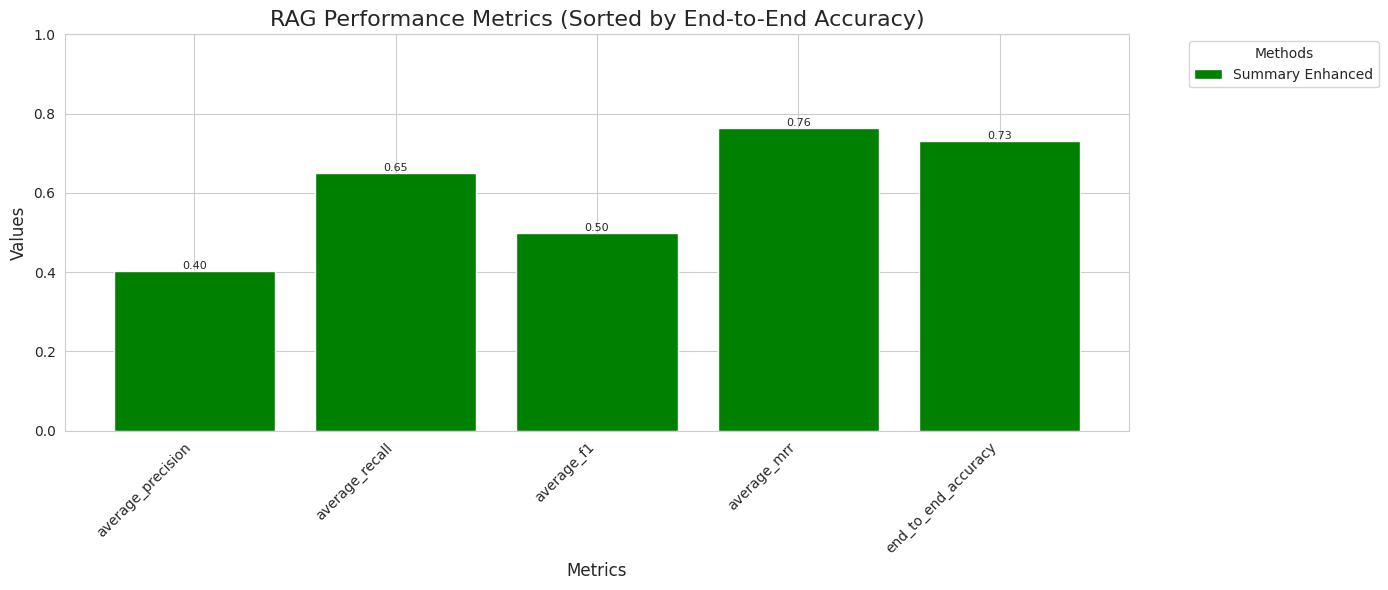

In [12]:
#let's visualize our accuracy
# plot_performance('evaluation/json_results', ['Basic RAG', 'Summary Enhanced'], colors=['skyblue', 'green'])
plot_performance('evaluation/json_results', [ 'Summary Enhanced'], colors=['green'])